In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/6_Preimplantation.EED_mKO_experiments.part7.NL_association_based_on_NL_affinity_and_H3K27me3_levels/'


In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# Bin clustering
indir = '../output/figures/5.2_Preimplantation.simplified_bin_clustering.part1.Performing_clustering.allelic_bias_correction/'
BIN_CLUSTER_FN = indir + 'FR231103.clustering_of_bins.binsize_100000.tsv'

# Gene information
GENESFN = HOME + 'references/mouse/mm10/genomic_element_info/FR200630.BioMart.mm10.all_genes.top_transcripts.txt.gz'
PARKFN = HOME + 'projects/preimplantation/DRA001066/data/tables/FR200923.Park_clusters_by_Ensembl_ID.tsv'

# Repeat information


# 0. Loading bin clustering

In [5]:
bin_clusters = pd.read_table(BIN_CLUSTER_FN)
bin_clusters['chrom'] = bin_clusters['chrom'].astype(str)
bin_clusters.groupby('Kcluster').size()

Kcluster
1    4623
2    3910
3    3990
4    2141
5    2490
6    4558
dtype: int64

# 1. Loading Kind data

In [6]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [7]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = [
    'no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b'
]

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['fusion_construct'] == 'Dam-Lmnb1']
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.treatment.isin(treatment_order)]
anno = anno[anno.DamID_PASS].reset_index(drop=True)
anno = anno.set_index('damid_name')


In [9]:
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
assert all(anno['treatment'].isin(treatment_order))
anno['treatment'] = pd.Categorical(anno['treatment'], categories=treatment_order)

In [10]:
tmp = anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size()
tmp[tmp>0]

fusion_construct  stage   genotype                treatment     
Dam-Lmnb1         zygote  CBAB6F1_x_CAST/EiJ      no_treatment       14
                          homozygous              no_treatment      107
                  2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           87
                                                  EED_mKO            54
                          CBAB6F1_x_CAST/EiJ      no_treatment       27
                                                  Lap2b              11
                                                  Cbx7(CD)-Lap2b     39
                          homozygous              no_treatment      218
                                                  Lap2b              31
                                                  Cbx7(CD)-Lap2b     28
                  8cell   CBAB6F1_x_CAST/EiJ      no_treatment       21
                                                  Cbx7(CD)-Lap2b     35
                          homozygous              no_treatment      212

In [11]:
anno_comb = anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']).size().reset_index().rename(columns={0: 'N'})
anno_comb = anno_comb[anno_comb.N > 0].reset_index(drop=True)
anno_comb

stage                genotype       treatment  is_heterozygous    N
0   zygote      CBAB6F1_x_CAST/EiJ    no_treatment             True   14
1   zygote              homozygous    no_treatment            False  107
2    2cell       C57BL/6J_x_JF1/Ms        EED_ctrl             True   87
3    2cell       C57BL/6J_x_JF1/Ms         EED_mKO             True   54
4    2cell      CBAB6F1_x_CAST/EiJ    no_treatment             True   27
5    2cell      CBAB6F1_x_CAST/EiJ           Lap2b             True   11
6    2cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b             True   39
7    2cell              homozygous    no_treatment            False  218
8    2cell              homozygous           Lap2b            False   31
9    2cell              homozygous  Cbx7(CD)-Lap2b            False   28
10   8cell      CBAB6F1_x_CAST/EiJ    no_treatment             True   21
11   8cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b             True   35
12   8cell              homozygous    no_treatment            False  212
13    mESC  129S1/SvImJ_x_CAST/EiJ    no_treatment             True  268

## 1.2 Loading mappability

In [12]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [13]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [14]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__Contact Frequency__

In [15]:
contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
    
    if info[0] not in ['Dam-only', 'Dam-Lmnb1']:
        print('Loading Dam-normalized CF values for: ', info)
        fn = fn.replace('contact_frequency', 'contact_frequency_damnorm')
    
    name = (info[1], info[2], info[3])
    
    if len(glob(fn)) == 0:
        print('CF does not exist for', info)
        continue
        
    contact_freq['combined'][name] =  load_count_file(fn)
    
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
            if info[0] not in ['Dam-only', 'Dam-Lmnb1']:
                fn = fn.replace('contact_frequency', 'contact_frequency_damnorm')
            contact_freq[parent][name] =  load_count_file(fn)

__in silico populations__

In [16]:
damid_insilico = {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(
        construct = info[0], stage = info[1], treatment = info[3], 
        sample = '*', genotype = gt_name, binsize=BINSIZE
    )
    fns = glob(fn)
    print(info, len(fns))
    name = (info[1], info[2], info[3])
    
    for fn in fns:
        counts = load_count_file(fn)
        counts = {c: counts[c].astype(int) for c in chrom_order}
        
        if name in damid_insilico['combined']:
            damid_insilico['combined'][name] = {c: damid_insilico['combined'][name][c] + counts[c] for c in chrom_order}
        else:
            damid_insilico['combined'][name] = counts

    # load parental
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = INSILICO.format(
                construct = info[0], stage = info[1], treatment = info[3], 
                sample = '1cell', genotype = gt_name, binsize=BINSIZE
            )
            fns = glob(fn)
            
            for fn in fns:
                counts =  load_count_file(fn)
                counts = {c: counts[c].astype(int) for c in chrom_order}

                if name in damid_insilico[parent]:
                    damid_insilico[parent][name] = {c: damid_insilico[parent][name][c] + counts[c] for c in chrom_order}
                else:
                    damid_insilico[parent][name] = counts
                

('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 2
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment', False) 2
('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b', False) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b', False) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment', False) 2
('Dam-Lmnb1', 'mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment', True) 1


__RPKM normalization of _in silico_ populations__

In [17]:
damid_insilico_rpkm = {p: dict() for p in ['maternal', 'paternal', 'combined']}

# Normalize DamID data
for sample, _ in anno.groupby(['stage', 'genotype', 'treatment']):
    gt = sample[1]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print(sample)
            continue


        if parent in ['maternal', 'paternal']:
            dm = sum([damid_insilico['maternal'][sample][c].sum() for c in chrom_order])
            dp = sum([damid_insilico['paternal'][sample][c].sum() for c in chrom_order])
            d = dm + dp

            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE, depth=d)

        else:
            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE)

('zygote', 'homozygous', 'no_treatment')
('zygote', 'homozygous', 'no_treatment')
('2cell', 'homozygous', 'no_treatment')
('2cell', 'homozygous', 'no_treatment')
('2cell', 'homozygous', 'Lap2b')
('2cell', 'homozygous', 'Lap2b')
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
('8cell', 'homozygous', 'no_treatment')
('8cell', 'homozygous', 'no_treatment')


__log2OE normalization of _in silico_ populations__

In [18]:
# RPKM normalize mappability data
mapab_rpkm = dict()
for gt in mapab_gt:
    mapab_rpkm[gt] = dict()
    
    for p in mapab_gt[gt]:
        m = mapab_gt[gt][p]
        
        if p in ['maternal', 'paternal']:
            dm = sum([mapab_gt[gt]['maternal'][c].sum() for c in chrom_order])
            dp = sum([mapab_gt[gt]['paternal'][c].sum() for c in chrom_order])
            d = dm+dp
            m = rpkm_normalize(m, binsize=BINSIZE, depth=d)
        else:
            m = rpkm_normalize(m, binsize=BINSIZE)
            
        mapab_rpkm[gt][p] = m
        

# Normalize DamID data
damid_insilico_logoe = {p: dict() for p in ['maternal', 'paternal', 'combined']}
for sample, _ in anno.groupby(['stage', 'genotype', 'treatment']):
    gt = sample[1]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print(sample, parent)
            continue
            
        rpkm = damid_insilico_rpkm[parent][sample]
        logoe = {c: np.log2( (rpkm[c] + .1) / (mapab_rpkm[gt][parent][c] + .1) ) for c in chrom_order}
        
        damid_insilico_logoe[parent][sample] = logoe


('zygote', 'homozygous', 'no_treatment') maternal
('zygote', 'homozygous', 'no_treatment') paternal
('2cell', 'homozygous', 'no_treatment') maternal
('2cell', 'homozygous', 'no_treatment') paternal
('2cell', 'homozygous', 'Lap2b') maternal
('2cell', 'homozygous', 'Lap2b') paternal
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') maternal
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') paternal
('8cell', 'homozygous', 'no_treatment') maternal
('8cell', 'homozygous', 'no_treatment') paternal


## 1.4 Loading allele visibility

In [19]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 2. Loading external data sets

In [20]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
df = pd.read_table(FN)
df[(df.is_heterozygous)&(df.target=='H3K4me3')]

sample_id technique          stage   target       treatment  \
34  GSE71434_006  ChIP-seq     PN5_zygote  H3K4me3              no   
35  GSE71434_007  ChIP-seq    2cell_early  H3K4me3              no   
36  GSE71434_008  ChIP-seq     2cell_late  H3K4me3              no   
37  GSE71434_009  ChIP-seq          4cell  H3K4me3              no   
38  GSE71434_010  ChIP-seq          8cell  H3K4me3              no   
39  GSE71434_011  ChIP-seq            ICM  H3K4me3              no   
40  GSE71434_012  ChIP-seq  E6.5_epiblast  H3K4me3              no   
41  GSE71434_013  ChIP-seq         cortex  H3K4me3              no   
42  GSE71434_014  ChIP-seq    2cell_early  H3K4me3  alpha_amanitin   
43  GSE71434_015  ChIP-seq    2cell_early  H3K4me3     aphidicolin   

    is_heterozygous        genotype genotype_maternal genotype_paternal  \
34             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
35             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
36             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
37             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
38             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
39             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
40             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
41             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
42             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   
43             True  C57BL/6N_x_PWK    C57BL_6NJ_snps      PWK_PhJ_snps   

   dataset_id control_id replicate library_layout       read_length_bp  
34   GSE71434       none     rep12         PAIRED  120;202;250;202;250  
35   GSE71434       none     rep12         PAIRED                  202  
36   GSE71434       none     rep12         PAIRED                  202  
37   GSE71434       none     rep12         PAIRED                  252  
38   GSE71434       none     rep12         PAIRED              202;252  
39   GSE71434       none      rep2         PAIRED              202;252  
40   GSE71434       none      rep1         PAIRED                  252  
41   GSE71434       none      rep1         PAIRED                  252  
42   GSE71434       none      rep1         PAIRED                  202  
43   GSE71434       none      rep1         PAIRED              202;252

In [21]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment.isin(['no', 'alpha_amanitin'])]
ext_anno = ext_anno[~ext_anno.target.isin(['H3'])]

# select samples where duplicate stages etc are available
sample_selection = {
    'H3K4me3': ext_anno.dataset_id.isin(['GSE71434', 'GSE73952']) & (~ext_anno.sample_id.isin(['GSE71434_016', 'GSE71434_019', 'GSE73952_028'])),
    'H3K27me3': ext_anno.dataset_id.isin(['GSE73952', 'GSE76687']) & (~ext_anno.sample_id.isin(['GSE76687_019'])),
    'H3K9me3': ext_anno.dataset_id.isin(['GSE97778', 'Encode_Hardison']) & (~ext_anno.sample_id.isin(['GSE76687_019', 'GSE97778_016'])),
    'accessibility': ext_anno.dataset_id.isin(['GSE66390']) & (~ext_anno.sample_id.isin(['GSE66390_007']))
}

select_ind = (ext_anno.dataset_id == ext_anno.dataset_id)
for target, ind in sample_selection.items():
    new_ind = (ext_anno.target != target) | ind
    select_ind = select_ind & new_ind
ext_anno = ext_anno[select_ind]

# select stages of interest
select_stages = [
    'sperm', 
    'growing_oocyte_7d', 'growing_oocyte_10d', 'growing_oocyte_14d', 'FG_oocyte', 'GV_oocyte', 'MII_oocyte', 
    'zygote', 'PN3_zygote', 'PN5_zygote', 
    '2cell_early', '2cell', '2cell_late',
    '4cell', '8cell', 'morula', 'blastocyst', 'ICM', 'mESC'
]

ext_anno = ext_anno[ext_anno.stage.isin(select_stages)]
ext_anno['stage'] = pd.Categorical(ext_anno['stage'], select_stages)

# only keep input control samples whose partner is still in sample sheet
valid_controls = ext_anno.control_id.unique()
ind_ctrl = (ext_anno.target == 'input') & ext_anno.sample_id.isin(valid_controls)
ind_rest = ext_anno.target != 'input'
ext_anno = ext_anno[ind_ctrl | ind_rest]

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [22]:
ext_anno[ext_anno.dataset_id == 'Encode_Hardison']

sample_id technique stage   target treatment  is_heterozygous  \
125  EncodeHardison_001  ChIP-seq  mESC  H3K9me3        no            False   
128  EncodeHardison_004  ChIP-seq  mESC    input        no            False   

      genotype genotype_maternal genotype_paternal       dataset_id  \
125  E14TG2a.4               NaN               NaN  Encode_Hardison   
128  E14TG2a.4               NaN               NaN  Encode_Hardison   

             control_id replicate library_layout read_length_bp  
125  EncodeHardison_004      rep1         SINGLE             45  
128                none      rep1         SINGLE             45

In [23]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: D[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        D = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: D[c][:len(mapab[c])] for c in chrom_order}

In [24]:
ext_data['maternal_corrected'] = dict()
ext_data['paternal_corrected'] = dict()

for sample in ext_data['allele_vis']:
    
    V = {c: np.copy(ext_data['allele_vis'][sample][c]) for c in chrom_order}
    for c in chrom_order:
        ind = (V[c] == 0) | np.isnan(V[c]) | np.isinf(V[c])
        V[c][ind] = 1
    
    for allele in ['maternal', 'paternal']:
        ext_data['%s_corrected' % allele][sample] = {c: np.copy(ext_data[allele][sample][c])/V[c] for c in chrom_order}    

# 3. Loading AT content

In [25]:
assert BINSIZE == 100000
FN = HOME + 'projects/preimplantation/GSE82185/data/mm10_gc_cov_100kb.tsv.gz'
gc_content_df = pd.read_table(FN, dtype={'chrom':str})

at_content = dict()

for chrom, df in gc_content_df.groupby('chrom'):
    if chrom not in chrom_order:
        continue
        
    bs = (df['end'] - df['start']).values[:-1]
    assert all(bs == BINSIZE)
    assert df['start'].values[0] == 0
    
    
    if len(df) > len(mapab[chrom]):
        y = (1 - df['GC']).values[:len(mapab[chrom])]
    else:
        y = np.zeros_like(mapab[chrom])
        y[:len(df)] = (1 - df['GC']).values
        
    at_content[chrom] = y

Text(0.5, 0, 'AT content')

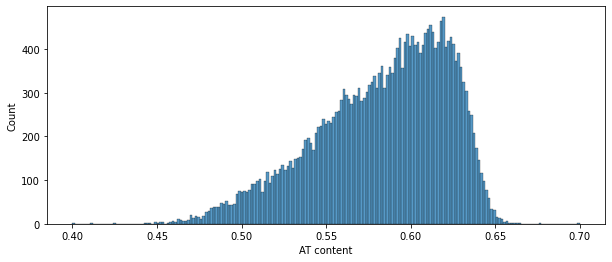

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
X = 1 - gc_content_df['GC']
sns.histplot(X.clip(0.4,0.7), bins=np.linspace(0.4,0.7,200), ax=ax)
ax.set_xlabel('AT content')

# Step 1: Defining high/mid/low affinity regions

In [27]:
CF_NL_AFFINITY_THRESH = [0.25, 0.75]
AT_NL_AFFINITY_THRESH = [0.56, 0.61]

In [28]:
selected_chroms = bin_clusters['chrom'].unique()

In [29]:
to_plot = dict()
cluster_bins_ind = {c: df['bin_ind'].values for c, df in bin_clusters.groupby('chrom')}
to_plot['Kcluster'] = np.concatenate([bin_clusters.loc[bin_clusters.chrom==c,'Kcluster'].values for c in selected_chroms])

for stage in ['zygote', 'mESC']:
    
    ind = (anno_comb.stage==stage)&(anno_comb.treatment=='no_treatment')
    for _, row in anno_comb[ind].iterrows():
        
        condition = (stage, row['genotype'], 'no_treatment')
        alleles = ['combined', 'maternal','paternal'] if row['is_heterozygous'] else ['combined']
        
        for allele in alleles:
            C = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
            name = '%s:%s' % (stage, allele) if row['is_heterozygous'] else stage + ':homozygous'
            to_plot[name] = C
            
to_plot['AT'] = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])
            
to_plot = pd.DataFrame(to_plot)

### CF distributions

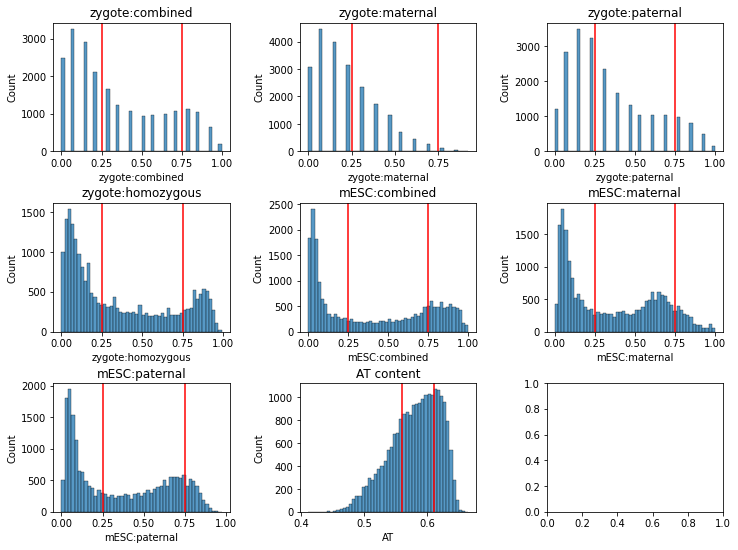

In [30]:
cols = to_plot.filter(like=':').columns.values
nplot = len(cols) + 1
ncol = 3
nrow = int(np.ceil(nplot/ncol))
fig, axes = plt.subplots(nrow,ncol,figsize=(ncol*4, nrow*3))
plt.subplots_adjust(hspace=.4, wspace=.4)

for i, stage in enumerate(cols):
    ax = axes.flatten()[i]
    ax.set_title(stage)
    sns.histplot(to_plot[stage], binwidth=0.02, ax=ax)
    
    ax.axvline(CF_NL_AFFINITY_THRESH[0], c='r')
    ax.axvline(CF_NL_AFFINITY_THRESH[1], c='r')
    
    
ax = axes.flatten()[i+1]
ax.set_title('AT content')
sns.histplot(to_plot['AT'], binwidth=0.005, ax=ax)
ax.axvline(AT_NL_AFFINITY_THRESH[0], c='r')
ax.axvline(AT_NL_AFFINITY_THRESH[1], c='r')

### What do the CF distributions look like per cluster?

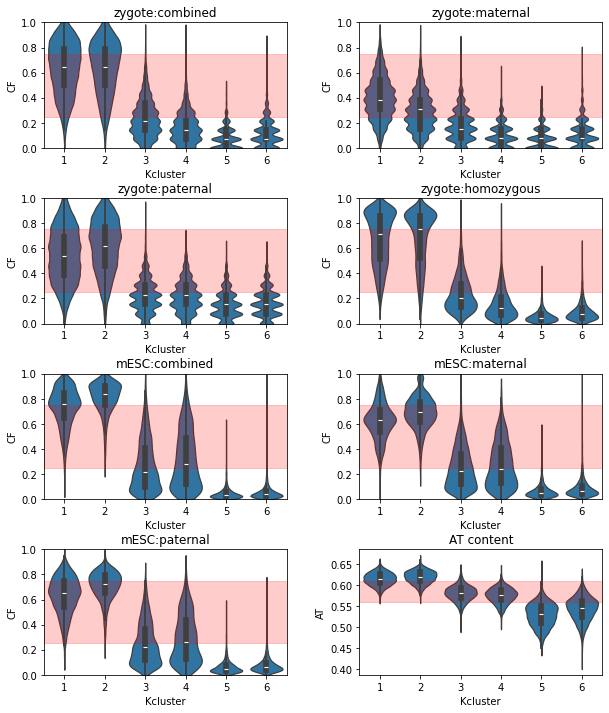

In [31]:
cols = to_plot.filter(like=':').columns.values
nplot = len(cols) + 1
ncol = 2
nrow = int(np.ceil(nplot/ncol))
fig, axes = plt.subplots(nrow,ncol,figsize=(ncol*5, nrow*3))
plt.subplots_adjust(hspace=.4, wspace=.3)

for iplot, stage in enumerate(cols):
    ax = axes.flatten()[iplot]
    
    sns.violinplot(x=to_plot['Kcluster'], y=to_plot[stage], ax=ax, density_norm='width')
    ax.set_ylim(0,1)
    ax.set_title(stage)
    ax.set_ylabel('CF')
    ax.axhspan(ymin=CF_NL_AFFINITY_THRESH[0], ymax=CF_NL_AFFINITY_THRESH[1], color='r', alpha=0.2)
    
ax = axes.flatten()[i+1]
ax.set_title('AT content')
sns.violinplot(x=to_plot['Kcluster'], y=to_plot['AT'], ax=ax, density_norm='width')
ax.axhspan(ymin=AT_NL_AFFINITY_THRESH[0], ymax=AT_NL_AFFINITY_THRESH[1], color='r', alpha=0.2)

### Comparing zygote CF to AT content

6308 15400
15778 5930
6308 15400
15778 5930
6308 15400
15778 5930


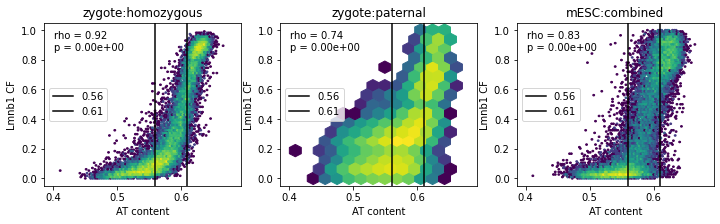

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

for icol, stage in enumerate(['zygote:homozygous', 'zygote:paternal', 'mESC:combined']):

    X = to_plot['AT']
    Y = to_plot[stage]

    ax = axes[icol]
    ax.set_title(stage)
    
    if stage == 'zygote:paternal':
        gs = 15
    else:
        gs = 100
    ax.hexbin(X, Y, bins='log', gridsize=gs, extent=[0.4,0.68,0,1])

    for t in AT_NL_AFFINITY_THRESH:
        ax.axvline(t, c='k', label=t)
        print((X<t).sum(), (X>t).sum())
    ax.legend(loc='center left')

    ax.set_xlabel('AT content')
    ax.set_ylabel('Lmnb1 CF')
    
    r, p = stats.spearmanr(X, Y)
    t = 'rho = %.2f\np = %.2e' % (r, p)
    ax.text(0.05, 0.95, t, transform=ax.transAxes, ha='left', va='top')
    
outfn = FIGOUTDIR + '1_Prep.Defining_NL_affinity.choosing_AT_thresholds.pdf'
plt.savefig(outfn, bbox_inches='tight')

### Comparing zygote log2OE to AT content

In [33]:
to_plot = dict()
cluster_bins_ind = {c: df['bin_ind'].values for c, df in bin_clusters.groupby('chrom')}
to_plot['Kcluster'] = np.concatenate([bin_clusters.loc[bin_clusters.chrom==c,'Kcluster'].values for c in selected_chroms])

for stage in ['zygote', 'mESC']:
    
    ind = (anno_comb.stage==stage)&(anno_comb.treatment=='no_treatment')
    for _, row in anno_comb[ind].iterrows():
        
        condition = (stage, row['genotype'], 'no_treatment')
        alleles = ['combined', 'maternal','paternal'] if row['is_heterozygous'] else ['combined']
        
        for allele in alleles:
            C = np.concatenate([damid_insilico_logoe[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
            name = '%s:%s' % (stage, allele) if row['is_heterozygous'] else stage + ':homozygous'
            to_plot[name] = C
            
to_plot['AT'] = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])
            
to_plot = pd.DataFrame(to_plot)

6308 15400
15778 5930
6308 15400
15778 5930
6308 15400
15778 5930


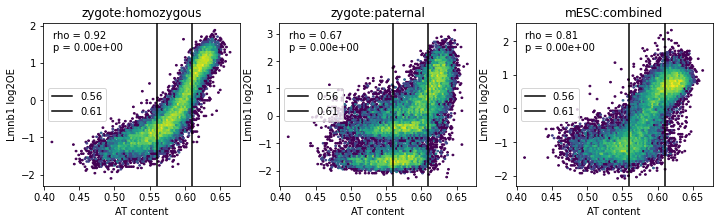

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

for icol, stage in enumerate(['zygote:homozygous', 'zygote:paternal', 'mESC:combined']):

    X = to_plot['AT']
    Y = to_plot[stage]

    ax = axes[icol]
    ax.set_title(stage)
    
#     if stage == 'zygote:paternal':
#         gs = 15
#     else:
#         gs = 100
    ax.hexbin(X, Y, bins='log')

    for t in AT_NL_AFFINITY_THRESH:
        ax.axvline(t, c='k', label=t)
        print((X<t).sum(), (X>t).sum())
    ax.legend(loc='center left')

    ax.set_xlabel('AT content')
    ax.set_ylabel('Lmnb1 log2OE')
    
    r, p = stats.spearmanr(X, Y)
    t = 'rho = %.2f\np = %.2e' % (r, p)
    ax.text(0.05, 0.95, t, transform=ax.transAxes, ha='left', va='top')
    
# outfn = FIGOUTDIR + '1_Prep.Defining_NL_affinity.choosing_AT_thresholds.pdf'
# plt.savefig(outfn, bbox_inches='tight')

### Defining NL affinity - based on homozygous zygote data

In [35]:
# nl_affinity = bin_clusters.copy()
# condition = ('zygote', 'homozygous', 'no_treatment')
# # condition = ('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment')
# allele = 'combined'

# nl_affinity['NL_affinity'] = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
# nl_affinity['NL_affinity_cat'] = 'NL:low'
# nl_affinity.loc[nl_affinity.NL_affinity >= NL_AFFINITY_THRESH[0], 'NL_affinity_cat'] = 'NL:mid'
# nl_affinity.loc[nl_affinity.NL_affinity >= NL_AFFINITY_THRESH[1], 'NL_affinity_cat'] = 'NL:high'

# nl_affinity['NL_affinity_cat'] = pd.Categorical(nl_affinity['NL_affinity_cat'], categories=['NL:low', 'NL:mid', 'NL:high'])

# nl_affinity.groupby(['NL_affinity_cat']).size().reset_index().rename(columns={0: 'N'})

In [36]:
# fig, ax = plt.subplots(figsize=(3.5,2))

# X = nl_affinity['NL_affinity'].values
# sns.histplot(X, binwidth=0.02, ax=ax, color='lightgrey')
# ax.set_title('Zygote CF values as NL affinity')
# ax.set_xlabel('CF')
# for t in NL_AFFINITY_THRESH:
#     ax.axvline(t, c='k')
    
# ax.set_xlim(0,1)

# for x, cat in zip([0.125, 0.5, 0.875], ['NL:low', 'NL:mid', 'NL:high']):
#     n = (nl_affinity['NL_affinity_cat']==cat).sum()
#     ax.text(x, 1500, '{}\n{:,}'.format(cat.strip('NL:'),n), ha='center', va='top')
    
# outfn = FIGOUTDIR + '1_Prep.Defining_NL_affinity.zygote_CF_distribution_with_thresholds.pdf'
# plt.savefig(outfn, bbox_inches='tight')

### Defining NL affinity - based on AT content

In [37]:
nl_affinity = bin_clusters.copy()

nl_affinity['NL_affinity'] = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])
nl_affinity['NL_affinity_cat'] = 'NL:low'
nl_affinity.loc[nl_affinity.NL_affinity >= AT_NL_AFFINITY_THRESH[0], 'NL_affinity_cat'] = 'NL:mid'
nl_affinity.loc[nl_affinity.NL_affinity >= AT_NL_AFFINITY_THRESH[1], 'NL_affinity_cat'] = 'NL:high'
nl_affinity['NL_affinity_cat'] = pd.Categorical(nl_affinity['NL_affinity_cat'], categories=['NL:low', 'NL:mid', 'NL:high'])

nl_affinity.groupby(['NL_affinity_cat']).size().reset_index().rename(columns={0: 'N'})

NL_affinity_cat     N
0          NL:low  6308
1          NL:mid  9470
2         NL:high  5934

In [38]:
fig, ax = plt.subplots(figsize=(3.5,2))

X = nl_affinity['NL_affinity'].values
sns.histplot(X, binwidth=0.005, ax=ax, color='lightgrey')
ax.set_title('AT content')
ax.set_xlabel('AT fraction')
for t in AT_NL_AFFINITY_THRESH:
    ax.axvline(t, c='k', label=t)
ax.legend(loc=(1,0))
    
ax.set_xlim(0.4,0.7)

for x, cat in zip([0.5, 0.58, 0.65], ['NL:low', 'NL:mid', 'NL:high']):
    n = (nl_affinity['NL_affinity_cat']==cat).sum()
    ax.text(x, 1000, '{}\n{:,}'.format(cat.strip('NL:'),n), ha='center', va='top')
    
outfn = FIGOUTDIR + '1_Prep.Defining_NL_affinity.AT_content_distribution_with_thresholds.pdf'
plt.savefig(outfn, bbox_inches='tight')

# Step 2: Defining H3K27me3 level at 2-cell stage

In [39]:
ext_sample = 'GSE76687_008'

In [40]:
K27_THRESH = [0.2, 0.8]

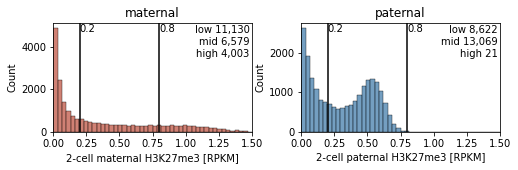

In [41]:
fig, axes = plt.subplots(1,2,figsize=(8,2))
plt.subplots_adjust(wspace=.25)

for icol, allele in enumerate(['maternal', 'paternal']):
    ax = axes[icol]
    
    a = 'combined' if allele == 'combined' else allele + '_corrected'
    C = np.concatenate([ext_data[a][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms])
    nl_affinity['H3K27me3_%s' % allele] = C
    
    sns.histplot(C, bins=np.linspace(0,1.6,50), ax=ax, color=color_dict['allele'][allele])
    ax.set_title(allele)
    
    for t in K27_THRESH:
        ax.axvline(t, c='k')
        p = (t - 0) / 1.5
        ax.text(p, 0.9, '%.1f' % t, ha='left', va='bottom', transform=ax.transAxes)
    
    n1 = (C < K27_THRESH[0]).sum()
    n2 = ((C>=K27_THRESH[0])&(C<K27_THRESH[1])).sum()
    n3 = (C >= K27_THRESH[1]).sum()
    
    t = 'low {:,}\nmid {:,}\nhigh {:,}'.format(n1,n2,n3)
    ax.text(0.99, 0.98, t, ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel('2-cell %s H3K27me3 [RPKM]' % allele)
    ax.set_xlim(0,1.5)
    
outfn = FIGOUTDIR + '1_Prep.Defining_H3K27me3_levels.2cell_H3K27me3_distribution_with_thresholds.pdf'
plt.savefig(outfn, bbox_inches='tight')

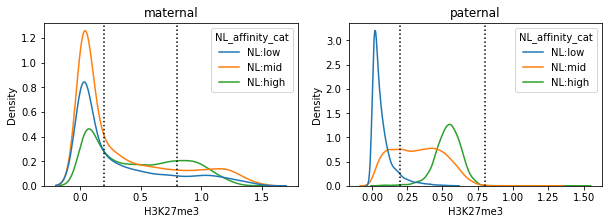

In [42]:
fig, axes = plt.subplots(1,2,figsize=(10,3))

for icol, allele in enumerate(['maternal', 'paternal']):
    ax = axes[icol]
    
    a = 'combined' if allele == 'combined' else allele + '_corrected'
    to_plot = nl_affinity.copy()
    C = np.concatenate([ext_data[a][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms])
    to_plot['H3K27me3'] = C
    
    sns.kdeplot(x=to_plot['H3K27me3'].clip(0,1.5), hue=to_plot['NL_affinity_cat'], common_norm=True, ax=ax)
    ax.set_title(allele)
    
    ax.axvline(K27_THRESH[0], c='k', ls=':')
    ax.axvline(K27_THRESH[1], c='k', ls=':')

In [43]:
for allele in ['maternal', 'paternal']:
    col = 'H3K27me3_%s' % allele
    col_cat = 'H3K27me3_%s_cat' % allele
    nl_affinity[col_cat] = 'K27:low'
    nl_affinity.loc[nl_affinity[col] >= K27_THRESH[0], col_cat] = 'K27:mid'
    nl_affinity.loc[nl_affinity[col] >= K27_THRESH[1], col_cat] = 'K27:high'
    
    nl_affinity[col_cat] = pd.Categorical(nl_affinity[col_cat], categories=['K27:low', 'K27:mid', 'K27:high'])

# exclude 21 paternal "high H3K27me3" bins
ind1 = (nl_affinity['H3K27me3_paternal_cat'] == 'K27:high')
print(ind1.sum())
# nl_affinity.loc[ind, 'H3K27me3_paternal_cat'] = np.nan

# exclude 2 NL:high-K27:low bins
ind2 = (nl_affinity['H3K27me3_paternal_cat'] == 'K27:low') & (nl_affinity['NL_affinity_cat'] == 'NL:high')
print(ind2.sum())
# nl_affinity.loc[ind,'H3K27me3_paternal_cat'] = np.nan

nl_affinity['paternal_exclude'] = (ind1 | ind2)

21
38


## Stage-specific categories

In [44]:
stage_sample_match = {
    'zygote': 'GSE76687_006',
    '2cell': 'GSE76687_008',
    '8cell': 'GSE76687_009',
    'mESC': 'GSE76687_018'
}

nrow = len(stage_sample_match)
fig, axes = plt.subplots(nrow,2,figsize=(8,3*nrow))
plt.subplots_adjust(wspace=.25, hspace=.5)

for irow, stage in enumerate(stage_sample_match.keys()):
    ext_sample = stage_sample_match[stage]
    
    for icol, allele in enumerate(['maternal', 'paternal']):
        ax = axes[irow,icol]
        
        

        a = 'combined' if allele == 'combined' else allele + '_corrected'
        a = 'combined' if stage=='mESC' else a
        C = np.concatenate([ext_data[a][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms])

        sns.histplot(C, bins=np.linspace(0,1.6,50), ax=ax, color=color_dict['allele'][allele])
        ax.set_title('%s - %s' % (stage,allele))

        for t in K27_THRESH:
            ax.axvline(t, c='k')
            p = (t - 0) / 1.5
            ax.text(p, 0.9, '%.1f' % t, ha='left', va='bottom', transform=ax.transAxes)
#         ax.axvline(0.25, c='k')

        n1 = (C < K27_THRESH[0]).sum()
        n2 = ((C>=K27_THRESH[0])&(C<K27_THRESH[1])).sum()
        n3 = (C >= K27_THRESH[1]).sum()

        t = 'low {:,}\nmid {:,}\nhigh {:,}'.format(n1,n2,n3)
        ax.text(0.99, 0.98, t, ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel('2-cell %s H3K27me3 [RPKM]' % allele)
        ax.set_xlim(0,1.5)
        

#         col_cat = 'H3K27me3_%s_%s_cat' % (stage,allele)
#         nl_affinity[col_cat] = 'K27:low'
#         nl_affinity.loc[C >= K27_THRESH[0], col_cat] = 'K27:mid'
#         nl_affinity.loc[C >= K27_THRESH[1], col_cat] = 'K27:high'
#         nl_affinity[col_cat] = pd.Categorical(nl_affinity[col_cat], categories=['K27:low', 'K27:mid', 'K27:high'])


# Save category file

In [45]:
outfn = FIGOUTDIR + 'NL_affinity_and_H3K27me3_categories.tsv.gz'
nl_affinity.to_csv(outfn, sep='\t', header=True, index=False)

# Numbers per category

## Numbers

In [46]:
nl_affinity.groupby(['NL_affinity_cat', 'H3K27me3_maternal_cat']).size().unstack()

H3K27me3_maternal_cat  K27:low  K27:mid  K27:high
NL_affinity_cat                                  
NL:low                    3695     1691       922
NL:mid                    5384     2466      1620
NL:high                   2051     2422      1461

In [47]:
nl_affinity.groupby(['NL_affinity_cat', 'H3K27me3_paternal_cat']).size().unstack()

H3K27me3_paternal_cat  K27:low  K27:mid  K27:high
NL_affinity_cat                                  
NL:low                    5839      469         0
NL:mid                    2745     6715        10
NL:high                     38     5885        11

In [48]:
a = 6715 + 10 + 5885 + 11
t = nl_affinity.groupby(['NL_affinity_cat', 'H3K27me3_paternal_cat']).size().unstack().sum().sum()
a/t

0.5812914517317612

In [49]:
nl_affinity.groupby(['H3K27me3_maternal_cat', 'H3K27me3_paternal_cat']).size().unstack()

H3K27me3_paternal_cat  K27:low  K27:mid  K27:high
H3K27me3_maternal_cat                            
K27:low                   5611     5514         5
K27:mid                   2117     4455         7
K27:high                   894     3100         9

## Visualize numbers on hexplot

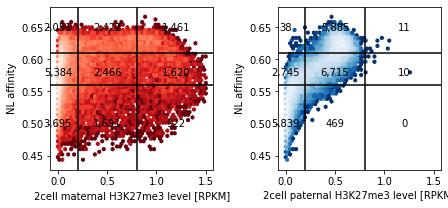

In [50]:
fig, axes = plt.subplots(1,2,figsize=(7,3))
plt.subplots_adjust(wspace=.4)

for icol, allele in enumerate(['maternal', 'paternal']):
    
    X = nl_affinity['H3K27me3_%s' % allele]
    Y = nl_affinity['NL_affinity']
    cmap = 'Reds_r' if allele == 'maternal' else 'Blues_r'
    
    ax = axes[icol]
#     ax.hexbin(X, Y, bins='log', cmap=cmap, extent=[0,1.5,0,1], gridsize=50, mincnt=1)
    ax.hexbin(X, Y, bins='log', cmap=cmap, extent=[0,1.5,0.44,0.67], gridsize=50, mincnt=1)
    
    for t in AT_NL_AFFINITY_THRESH:
        ax.axhline(t, c='k')
    for t in K27_THRESH:
        ax.axvline(t, c='k')
        
    ax.set_xlabel('2cell %s H3K27me3 level [RPKM]' % allele)
    ax.set_ylabel('NL affinity')
    
    for x, k27cat in zip([0,0.5,1.2], ['K27:low', 'K27:mid', 'K27:high']):
        a = (nl_affinity['H3K27me3_%s_cat' % allele] == k27cat)
#         for y, nlcat in zip([0.1,0.5,0.9], ['NL:low', 'NL:mid', 'NL:high']):
        for y, nlcat in zip([0.5,0.58,0.65], ['NL:low', 'NL:mid', 'NL:high']):
            b = (nl_affinity['NL_affinity_cat'] == nlcat)
            n = (a&b).sum()
            ax.text(x, y, '{:,}'.format(n), ha='center', va='center')
            
outfn = FIGOUTDIR + '1_Prep.relating_NL_affinity_and_H3K27me3.visualizing_thresholds.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Support function

In [51]:
import matplotlib

In [52]:
def plot_heatmap_patches(M, cmap, vrange, ax, text_fmt='{}'):
    
    cmap_func = matplotlib.colormaps.get_cmap(cmap)
    
    if len(vrange) == 2:
        vmin, vmax = vrange
    else:
        vmin = np.nanmin(M)
        vmax = np.nanmax(M)
    
    for y in range(M.shape[0]):
        for x in range(M.shape[1]):

            clrval = (M[y,x] - vmin) / (vmax - vmin)
            R = matplotlib.patches.Rectangle((x,y), 1, 1, color=cmap_func(clrval), lw=0)
            ax.add_patch(R)
            ax.text(x+.5, y+.5, text_fmt.format(M[y,x]), ha='center', va='center')
            
    n = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    p = matplotlib.cm.ScalarMappable(norm = n, cmap=cmap)
    cbar = plt.colorbar(p, ax=ax, shrink=0.5)
    ax.set_xlim(0,M.shape[1])
    ax.set_ylim(0,M.shape[0])
    
    return cbar

## Visualize average NL affinity and H3K27me3 per category

In [53]:
# select data
nrow = 2
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)

for irow, allele in enumerate(['maternal', 'paternal']):

    for icol, metric in enumerate(['NL_affinity', 'H3K27me3_%s' % allele]):
    
        to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele, metric]].copy()
        to_plot.columns = ['NL_cat', 'H3K27me3_cat', metric]
        if allele == 'paternal':
            to_plot.loc[nl_affinity['paternal_exclude'], metric] = np.nan
        to_plot = to_plot.groupby(['NL_cat', 'H3K27me3_cat']).mean().unstack()
        ax = axes[irow, icol]

        if metric == 'NL_affinity':
            cmap = 'viridis'
            vrange = [0.5, 0.65]
        else:
            cmap = 'Greens'
            vrange = [0,1.1]
            
        cbar = plot_heatmap_patches(to_plot.values, cmap, vrange, ax, text_fmt='{:.02f}')
        cbar.ax.set_ylabel(metric)

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels([c[1] for c in to_plot.columns.values])
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot.index)
        ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

        ax.set_aspect('equal')

        if col == 'NL_affinity':
            ax.set_title('%s categories\navg. NL affinity' % (allele, metric))
        else:
            ax.set_title('%s categories\navg. %s H3K27me3' % (allele, metric))

outfn = FIGOUTDIR + '1_Prep.relating_NL_affinity_and_H3K27me3.avg_NL_affinity_and_H3K27me3_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Visualize numbers in heatmap

In [54]:
def plot_metric_per_category(metric):
    assert metric in ['count', 'enrichment']
    
    # select data
    nrow = 1
    ncol = 2

    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
    plt.subplots_adjust(hspace=.4, wspace=.4)

    for icol, allele in enumerate(['maternal', 'paternal']):

        to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
        to_plot.columns = ['NL_affinity', 'H3K27me3_level']
        ax = axes[icol]

        if metric == 'count':
            to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
            cbar = plot_heatmap_patches(to_plot.values, 'bone_r', [], ax, text_fmt='{:,}')
            cbar.ax.set_ylabel('number of bins')

        elif metric == 'enrichment':
            to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
            t = to_plot.values.sum()
            a = np.atleast_2d(to_plot.sum(axis=1)).T / t
            b = np.atleast_2d(to_plot.sum(axis=0)) / t
            expected = np.dot(a,b)*t
            to_plot = np.log2(to_plot / expected)
            cbar = plot_heatmap_patches(to_plot.values, 'coolwarm', [-2,2], ax, text_fmt='{:.1f}')
            cbar.ax.set_ylabel('enrichment of bins [log2OE]')

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(to_plot.columns.values)
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot.index)
        ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

        ax.set_aspect('equal')

        ax.set_title(allele)

    return

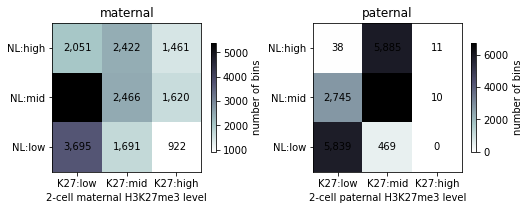

In [55]:
plot_metric_per_category('count')
outfn = FIGOUTDIR + '1_Prep.Number_of_bins_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


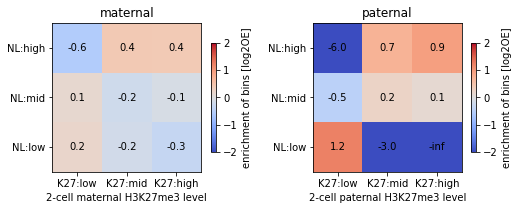

In [56]:
plot_metric_per_category('enrichment')
outfn = FIGOUTDIR + '1_Prep.Enrichment_of_bins_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Distribution of centromeric regions over categories

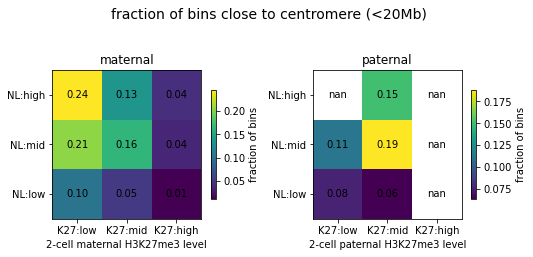

In [57]:

metric = 'fraction'
dist_from_cent = 20e6

# select data
nrow = 1
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)

for icol, allele in enumerate(['maternal', 'paternal']):

    if (metric != 'count') and (allele == 'paternal'):
        to_plot = nl_affinity.loc[~nl_affinity.paternal_exclude,['end', 'NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
    else:
        to_plot = nl_affinity[['end', 'NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
    to_plot.columns = ['end', 'NL_affinity', 'H3K27me3_level']
    ax = axes[icol]

    if metric == 'count':
        ind = (to_plot['end'] <= dist_from_cent)
        to_plot = to_plot[ind].groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        cbar = plot_heatmap_patches(to_plot.values, 'bone_r', [], ax, text_fmt='{:,}')
        cbar.ax.set_ylabel('number of bins')
        title = 'number of bins close to centromere (<%dMb)' % int(dist_from_cent/1e6)

    elif metric == 'enrichment':
        ind = (to_plot['end'] <= dist_from_cent)
        to_plot = to_plot[ind].groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        to_plot = to_plot / to_plot_all
        t = to_plot.values.sum()
        a = np.atleast_2d(to_plot.sum(axis=1)).T / t
        b = np.atleast_2d(to_plot.sum(axis=0)) / t
        expected = np.dot(a,b)*t
        to_plot = np.log2(to_plot / expected)
        cbar = plot_heatmap_patches(to_plot.values, 'coolwarm', [-2,2], ax, text_fmt='{:.1f}')
        cbar.ax.set_ylabel('enrichment of bins [log2OE]')
        title = 'enrichment of bins close to centromere (<%dMb)' % int(dist_from_cent/1e6)
        
    elif metric == 'fraction':
        ind = (to_plot['end'] <= dist_from_cent)
        to_plot_all = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        to_plot = to_plot[ind].groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        to_plot = to_plot / to_plot_all
        cbar = plot_heatmap_patches(to_plot.values, 'viridis', [], ax, text_fmt='{:.2f}')
        cbar.ax.set_ylabel('fraction of bins')
        title = 'fraction of bins close to centromere (<%dMb)' % int(dist_from_cent/1e6)
        

    ax.set_xticks(np.arange(3)+.5)
    ax.set_xticklabels(to_plot.columns.values)
    ax.set_yticks(np.arange(3)+.5)
    ax.set_yticklabels(to_plot.index)
    ax.set_xlabel('2-cell %s H3K27me3 level' % allele)
    ax.set_aspect('equal')

    ax.set_title(allele)
plt.suptitle(title, fontsize=14)
outfn = FIGOUTDIR + '3_Other.fraction_of_centromeric_bins_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Relate categories to cluster analysis

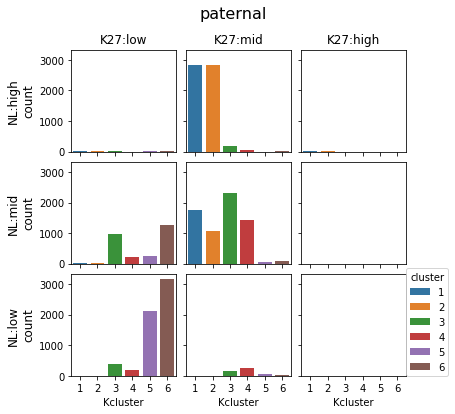

In [58]:

for allele in ['maternal', 'paternal']:
    fig, axes = plt.subplots(3,3,figsize=(6,6), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    clrpal = {k: sns.color_palette('tab10', n_colors=10)[k-1] for k in nl_affinity['Kcluster'].sort_values().unique()}

    for irow, nlcat in enumerate(['NL:high', 'NL:mid', 'NL:low']):
        for icol, k27cat in enumerate(['K27:low', 'K27:mid', 'K27:high']):

            ax = axes[irow,icol]

            ind = (nl_affinity['NL_affinity_cat']==nlcat) & (nl_affinity['H3K27me3_%s_cat' % allele]==k27cat)
            df = nl_affinity[ind].copy()
            df['Kcluster'] = pd.Categorical(df['Kcluster'], categories=np.arange(1,7))
            df = df.groupby('Kcluster').size().reset_index().rename(columns={0:'N'})

            sns.barplot(x=df['Kcluster'], y=df['N'], hue=df['Kcluster'], dodge=False, ax=ax, palette=clrpal)


            if irow == 0:
                ax.set_title(k27cat, fontsize=12)
            if icol == 0:
                ax.set_ylabel(nlcat + '\ncount', fontsize=12)
            if (icol == 2) and (irow==2):
                ax.legend(loc=(1,0), title='cluster')
            else:
                ax.legend_.remove()

    plt.suptitle(allele, fontsize=16)

    outfn = FIGOUTDIR + '1_Prep.Relating_Fig2_clusters_to_categories.%s_allele.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    plt.show()
    plt.close()

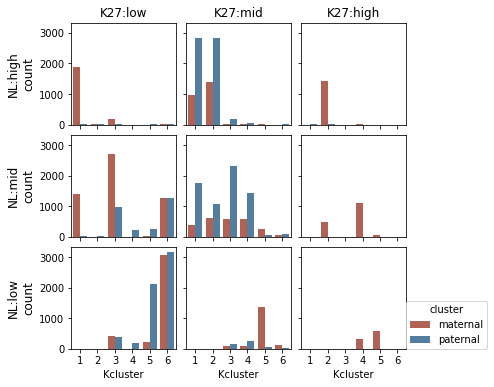

In [59]:
fig, axes = plt.subplots(3,3,figsize=(6,6), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

clrpal = {k: sns.color_palette('tab10', n_colors=10)[k-1] for k in nl_affinity['Kcluster'].sort_values().unique()}

for irow, nlcat in enumerate(['NL:high', 'NL:mid', 'NL:low']):
    for icol, k27cat in enumerate(['K27:low', 'K27:mid', 'K27:high']):

        ax = axes[irow,icol]

        to_plot = list()
        
        for allele in ['maternal','paternal']:
            ind = (nl_affinity['NL_affinity_cat']==nlcat) & (nl_affinity['H3K27me3_%s_cat' % allele]==k27cat)
            df = nl_affinity[ind].copy()
            df['Kcluster'] = pd.Categorical(df['Kcluster'], categories=np.arange(1,7))
            df = df.groupby('Kcluster').size().reset_index().rename(columns={0:'N'})
            df['allele'] = allele
            to_plot.append(df)
            
        to_plot = pd.concat(to_plot, axis=0)

        sns.barplot(
            x=to_plot['Kcluster'], y=to_plot['N'], hue=to_plot['allele'], 
            dodge=True, ax=ax, palette=color_dict['allele']
        )


        if irow == 0:
            ax.set_title(k27cat, fontsize=12)
        if icol == 0:
            ax.set_ylabel(nlcat + '\ncount', fontsize=12)
        if (icol == 2) and (irow==2):
            ax.legend(loc=(1,0), title='cluster')
        else:
            ax.legend_.remove()
            
outfn = FIGOUTDIR + '1_Prep.Relating_Fig2_clusters_to_categories.both_alleles.pdf'
plt.savefig(outfn, bbox_inches='tight')
plt.show()
plt.close()

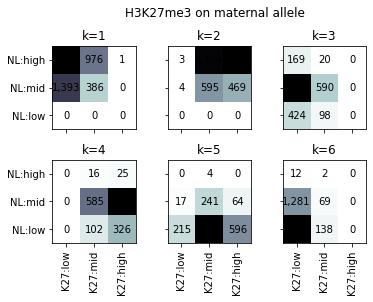

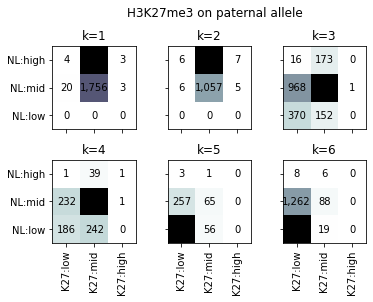

In [60]:

for allele in ['maternal', 'paternal']:

    nplot = len(nl_affinity['Kcluster'].unique())
    ncol = 3
    nrow = int(np.ceil(nplot/ncol))
    fig, axes = plt.subplots(nrow,ncol, figsize=(ncol*2, nrow*2), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=.1, wspace=.1)
    counter = 0

    for k, df in nl_affinity.groupby('Kcluster'):

        df = df.copy()
        to_plot = df[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
        to_plot.columns = ['NL_affinity', 'H3K27me3_level']

        ax = axes.flatten()[counter]
        counter += 1

        to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        cbar = plot_heatmap_patches(to_plot.values, 'bone_r', [], ax, text_fmt='{:,}')
        cbar.ax.set_ylabel('number of bins')
        cbar.remove()

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(to_plot.columns.values)
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot.index)


        ax.set_aspect('equal')
        ax.set_title('k=%d' % k)

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.suptitle('H3K27me3 on %s allele' % allele)
    
    outfn = FIGOUTDIR + '1_Prep.Relating_Fig2_clusters_to_categories.%s_allele.v2.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    plt.show()
    plt.close()

# Intermezzo: Compare NLaffinity/H3K27me3 of chrX to somatic chroms

__Collecting data__

In [169]:
ext_sample = 'GSE76687_008'

# define which bin should be selected (for somatic chroms: use bins used for cluster; for X: repeat same selection)
filt_ind = cluster_bins_ind
ind = (mapab['X'] > MINMAP) & allele_filt_gt['CBAB6F1_x_CAST/EiJ']['X'] & allele_filt_gt['129S1/SvImJ_x_CAST/EiJ']['X'] & (~ext_data['blacklisted']['X'])
print('X filt', ind.mean(), ind.sum())
filt_ind['X'] = np.arange(0,len(mapab['X']))[ind]
to_plot = pd.DataFrame({'chrom': np.concatenate([np.repeat(c, len(filt_ind[c])) for c in chrom_order[:-1]])})
to_plot['chrom_cat'] = to_plot['chrom'].apply(func = lambda c: 'X' if c == 'X' else 'somatic')
to_plot['NL_affinity'] = np.concatenate([at_content[c][filt_ind[c]] for c in chrom_order[:-1]])
to_plot['NL_affinity_cat'] = 'NL:low'
to_plot.loc[to_plot.NL_affinity >= AT_NL_AFFINITY_THRESH[0], 'NL_affinity_cat'] = 'NL:mid'
to_plot.loc[to_plot.NL_affinity >= AT_NL_AFFINITY_THRESH[1], 'NL_affinity_cat'] = 'NL:high'
to_plot['NL_affinity_cat'] = pd.Categorical(to_plot['NL_affinity_cat'], categories=['NL:low', 'NL:mid', 'NL:high'])

for allele in ['maternal', 'paternal']:
    
    # get H3K27me3 levels
    a = 'combined' if allele == 'combined' else allele + '_corrected'
    C = np.concatenate([ext_data[a][ext_sample][c][filt_ind[c]] for c in chrom_order[:-1]])
    to_plot['H3K27me3_%s' % allele] = C
    
    # get CF
    sample = ('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
    D = np.concatenate([contact_freq[allele][sample][c][filt_ind[c]] for c in chrom_order[:-1]])
    to_plot['CF_%s' % allele] = D
#     if allele == 'paternal':
#         sample_ls = anno[(anno.stage==sample[0])&(anno.genotype==sample[1])&(anno.treatment==sample[2])&(anno.sex=='female')].index.values
#         Y = np.array([damid_bi])
        
    
    # artificially amplify paternal H3K27me3 on chrX
    if allele == 'paternal':
        to_plot.loc[to_plot['chrom']=='X','H3K27me3_paternal'] = to_plot.loc[to_plot['chrom']=='X','H3K27me3_paternal']*2
    

    col = 'H3K27me3_%s' % allele
    col_cat = 'H3K27me3_%s_cat' % allele
    to_plot[col_cat] = 'K27:low'
    to_plot.loc[to_plot[col] >= K27_THRESH[0], col_cat] = 'K27:mid'
    to_plot.loc[to_plot[col] >= K27_THRESH[1], col_cat] = 'K27:high'
    to_plot[col_cat] = pd.Categorical(to_plot[col_cat], categories=['K27:low', 'K27:mid', 'K27:high'])

X filt 0.7009947337624342 1198


__Distribution over categories__

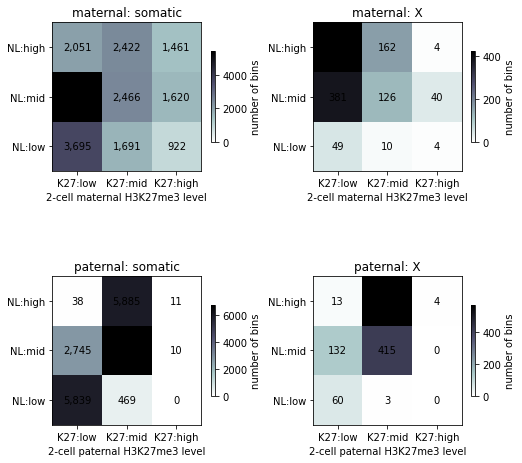

In [166]:
metric = 'count'

# select data
nrow = 2
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)

for icol, chrom in enumerate(['somatic', 'X']):
    for irow, allele in enumerate(['maternal', 'paternal']):

        to_plot_tmp = to_plot.loc[to_plot.chrom_cat==chrom,['NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
        to_plot_tmp.columns = ['NL_affinity', 'H3K27me3_level']
        ax = axes[irow,icol]


        to_plot_tmp = to_plot_tmp.groupby(['NL_affinity', 'H3K27me3_level']).size().unstack()
        cbar = plot_heatmap_patches(to_plot_tmp.values, 'bone_r', [0,to_plot_tmp.max().max()], ax, text_fmt='{:,}')
        cbar.ax.set_ylabel('number of bins')


        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(to_plot_tmp.columns.values)
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot_tmp.index)
        ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

        ax.set_aspect('equal')

        ax.set_title('%s: %s' % (allele,chrom))

outfn = FIGOUTDIR + 'chrX.distribution_over_categories.X_vs_somatic.pdf'
plt.savefig(outfn, bbox_inches='tight')

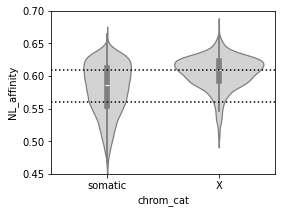

In [167]:
fig, ax = plt.subplots(figsize=(4,3))

sns.violinplot(x=to_plot['chrom_cat'], y=to_plot['NL_affinity'], color='lightgrey')

for t in AT_NL_AFFINITY_THRESH:
    ax.axhline(t, c='k', ls=':')
    
ax.set_ylim(0.45, 0.7)
outfn = FIGOUTDIR + 'chrX.AT_content.X_vs_somatic.pdf'
plt.savefig(outfn, bbox_inches='tight')

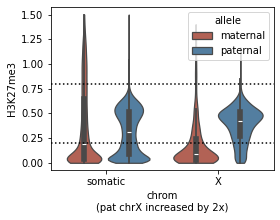

In [168]:
fig, ax = plt.subplots(figsize=(4,3))

tmp = to_plot[['chrom_cat', 'NL_affinity', 'H3K27me3_maternal', 'H3K27me3_paternal']].copy().melt(id_vars=['chrom_cat','NL_affinity'], var_name='allele', value_name='H3K27me3')
tmp['allele'] = tmp['allele'].apply(func = lambda a: a.split('_')[1])
sns.violinplot(x=tmp['chrom_cat'], y=tmp['H3K27me3'].clip(0,1.5), hue=tmp['allele'], 
               cut=0, palette=color_dict['allele'])


for t in K27_THRESH:
    ax.axhline(t, c='k', ls=':')
    
ax.set_xlabel('chrom\n(pat chrX increased by 2x)')
    
outfn = FIGOUTDIR + 'chrX.H3K27me3.X_vs_somatic.pdf'
plt.savefig(outfn, bbox_inches='tight')

Text(0.5, 0, 'chrom\n(based on both male and female embryos)')

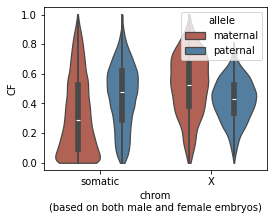

In [170]:
fig, ax = plt.subplots(figsize=(4,3))

tmp = to_plot[['chrom_cat', 'NL_affinity', 'CF_maternal', 'CF_paternal']].copy().melt(id_vars=['chrom_cat','NL_affinity'], var_name='allele', value_name='CF')
tmp['allele'] = tmp['allele'].apply(func = lambda a: a.split('_')[1])
sns.violinplot(x=tmp['chrom_cat'], y=tmp['CF'].clip(0,1.5), hue=tmp['allele'], 
               cut=0, palette=color_dict['allele'])
ax.set_xlabel('chrom\n(based on both male and female embryos)')

# Step 3: Explore CF of various conditions in the categories

In [61]:
def compute_shannon_entropy(cf_vals):
    
    
    cf_vals = np.copy(cf_vals).clip(0.1,0.99)
    
    is_nan = np.isnan(cf_vals)
    cf_vals[is_nan] = 1
    
    p_1 = cf_vals
    p_0 = (1 - cf_vals)
    
    outcome_1 = - p_1 * np.log(p_1)
    outcome_0 = - p_0 * np.log(p_0)
    outcome = outcome_1 + outcome_0
    outcome[is_nan] = np.nan
    
    return outcome_1 + outcome_0

# Average CF per category

In [62]:
from collections import defaultdict
import itertools

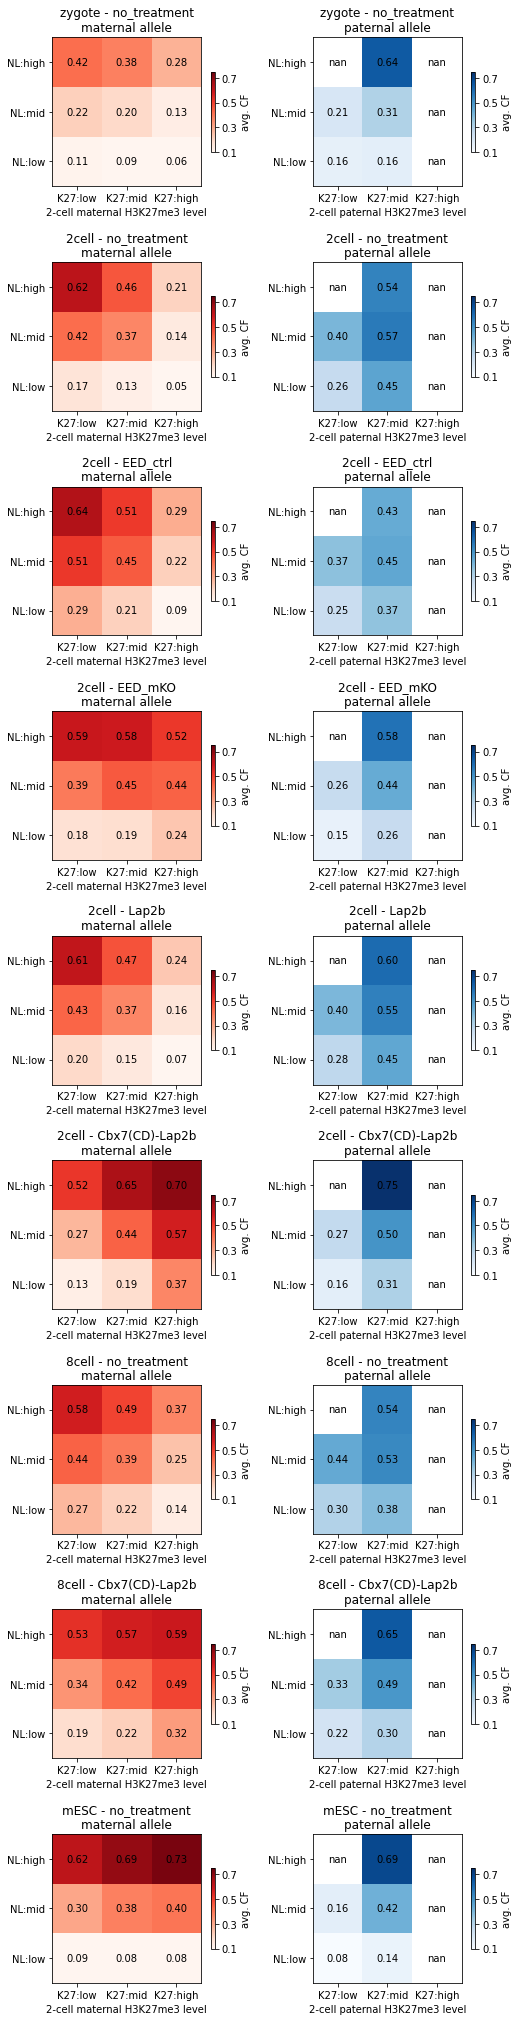

In [63]:
# select data
ind = (anno.is_heterozygous)
g_anno = anno[ind].groupby(['stage','treatment','genotype'])
nrow = len(list(g_anno))
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)
irow = -1

metric = 'CF'

for condition, _ in g_anno:
    irow += 1

    for icol, allele in enumerate(['maternal', 'paternal']):

        to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
        to_plot.columns = ['NL_affinity', 'H3K27me3_level']
        ax = axes[irow,icol]

        # collect CF values for the sample
        name = (condition[0], condition[2], condition[1])
        
        if metric in ['CF', 'fraction_variable']:
            to_plot['value'] = np.concatenate([contact_freq[allele][name][c][cluster_bins_ind[c]] for c in selected_chroms])
            cmap = {'maternal': 'Reds', 'paternal': 'Blues'}[allele]
            clrrange = [0.1,0.75]
        else:
            to_plot['value'] = np.concatenate([damid_insilico_logoe[allele][name][c][cluster_bins_ind[c]] for c in selected_chroms])
            cmap = 'coolwarm'
            clrrange = [-0.6,0.6]
        
        if allele == 'paternal':
            ind = nl_affinity['paternal_exclude']
            to_plot.loc[ind,'value'] = np.nan

        # mask bins with low allele visibility
        if allele != 'combined':
            filt = np.concatenate([allele_filt_gt[condition[2]][c][cluster_bins_ind[c]] for c in selected_chroms])
            to_plot.loc[~filt,'value'] = np.nan

        # summarize per cateogory and plot
        if metric == 'fraction_variable':
            get_frac_var = lambda c: np.nanmean((c > 0.2) & (c < 0.6))
            to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).agg({'value':get_frac_var}).unstack()
        else:
            to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).agg({'value':np.nanmean}).unstack()
        to_plot.columns = [c[1] for c in to_plot.columns.values]
        

        cbar = plot_heatmap_patches(to_plot.values, cmap, clrrange, ax, text_fmt='{:.2f}')
        cbar.ax.set_ylabel('avg. %s' % metric)
        if metric == 'CF':
            cbar.ax.set_yticks([0.1, 0.3, 0.5, 0.7])

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(to_plot.columns.values)
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot.index)
        ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

        ax.set_aspect('equal')

        ax.set_title('%s - %s\n%s allele' % (condition[0], condition[1], allele))
        
outfn = FIGOUTDIR + '2_CF_per_category.heatmap_avg_CF_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

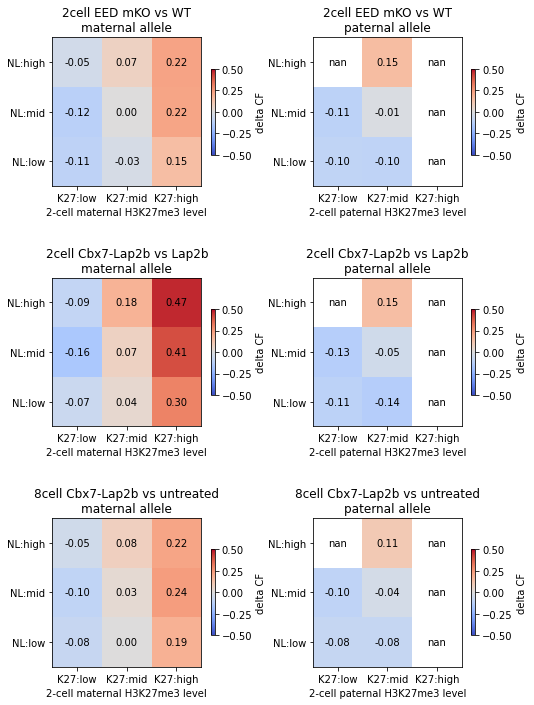

In [64]:
comparison_ls = {
    '2cell EED mKO vs WT': [('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')],
    '2cell Cbx7-Lap2b vs Lap2b': [('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b'), ('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')],
    '8cell Cbx7-Lap2b vs untreated': [('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')]
}

# select data
nrow = len(comparison_ls.keys())
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)
irow = -1

metric = 'CF'


for comparison in comparison_ls.keys():
    irow += 1

    for icol, allele in enumerate(['maternal', 'paternal']):


        ax = axes[irow,icol]

        results = dict()
        for condition in comparison_ls[comparison]:
            to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele]].copy()
            to_plot.columns = ['NL_affinity', 'H3K27me3_level']
        
            if metric in ['CF', 'fraction_variable']:
                to_plot['value'] = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
                cmap = {'maternal': 'Reds', 'paternal': 'Blues'}[allele]
                clrrange = [0.2,0.8]
            else:
                to_plot['value'] = np.concatenate([damid_insilico_logoe[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
                cmap = 'coolwarm'
                clrrange = [-0.6,0.6]

            if allele == 'paternal':
                ind = nl_affinity['paternal_exclude']
                to_plot.loc[ind,'value'] = np.nan

            # mask bins with low allele visibility
            if allele != 'combined':
                filt = np.concatenate([allele_filt_gt[condition[1]][c][cluster_bins_ind[c]] for c in selected_chroms])
                to_plot.loc[~filt,'value'] = np.nan

            # summarize per cateogory and plot
            if metric == 'fraction_variable':
                get_frac_var = lambda c: np.nanmean((c > 0.2) & (c < 0.6))
                to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).agg({'value':get_frac_var}).unstack()
            else:
                to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).agg({'value':np.nanmean}).unstack()
            to_plot.columns = [c[1] for c in to_plot.columns.values]
            
            results[condition] = to_plot

        c1 = comparison_ls[comparison][0]
        c2 = comparison_ls[comparison][1]
        to_plot = results[c2] - results[c1]
        clrrange = [-.5,.5]
        cmap = 'coolwarm'
        cbar = plot_heatmap_patches(to_plot.values, cmap, clrrange, ax, text_fmt='{:.2f}')
        cbar.ax.set_ylabel('delta %s' % metric)

        ax.set_xticks(np.arange(3)+.5)
        ax.set_xticklabels(to_plot.columns.values)
        ax.set_yticks(np.arange(3)+.5)
        ax.set_yticklabels(to_plot.index)
        ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

        ax.set_aspect('equal')

        ax.set_title('%s\n%s allele' % (comparison, allele))
        
outfn = FIGOUTDIR + '2_CF_per_category.heatmap_avg_delta_CF_per_category.pdf'
plt.savefig(outfn, bbox_inches='tight')

# Distance to nearest high NL affinity region
Can that explain why paternal NL:low+K27:mid has higher NL association than NL:low+K27:low?

In [65]:
to_plot = nl_affinity.copy()

for chrom, df in to_plot.groupby('chrom'):
    
    high_bins = df.loc[df.NL_affinity_cat.isin(['NL:high', 'NL:mid']), 'bin_ind'].values
    
    for irow, row in df.iterrows():
        
        i = row['bin_ind']
        nearest = np.min(abs(high_bins - i)) * BINSIZE
        to_plot.loc[irow,'nearest_NL:high_kb'] = int(nearest/1e3)

In [66]:
to_plot['nearest_NL:high_log'] = np.log10(to_plot['nearest_NL:high_kb']*1000 + 1)

In [67]:
for irow, row in tqdm(to_plot.iterrows(), total=len(to_plot)):
    
    a = row['bin_ind'] - 10
    b = row['bin_ind'] + 10
    ind = (to_plot['chrom'] == row['chrom']) & (to_plot['bin_ind'] >= a) & (to_plot['bin_ind'] <= b)
    to_plot.loc[irow,'avg_AT_1Mb'] = to_plot.loc[ind,'NL_affinity'].mean()

  0%|          | 0/21712 [00:00<?, ?it/s]

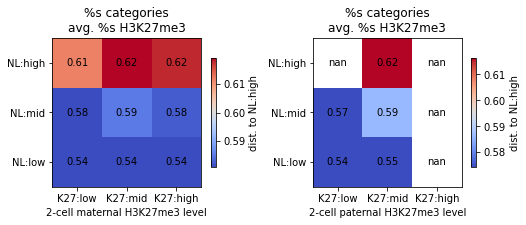

In [68]:
# select data
nrow = 1
ncol = 2


fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)

metric = 'avg_AT_1Mb'

for icol, allele in enumerate(['maternal', 'paternal']):

    to_plot_sub = to_plot[['NL_affinity_cat', 'H3K27me3_%s_cat' % allele, metric]].copy()
    to_plot_sub.columns = ['NL_cat', 'H3K27me3_cat', metric]
    if allele == 'paternal':
        to_plot_sub.loc[nl_affinity['paternal_exclude'], metric] = np.nan
    to_plot_sub = to_plot_sub.groupby(['NL_cat', 'H3K27me3_cat']).mean().unstack()
    ax = axes[icol]

    cmap = 'coolwarm'
    cbar = plot_heatmap_patches(to_plot_sub.values, cmap, [], ax, text_fmt='{:.2f}')
    cbar.ax.set_ylabel('dist. to NL:high')

    ax.set_xticks(np.arange(3)+.5)
    ax.set_xticklabels([c[1] for c in to_plot_sub.columns.values])
    ax.set_yticks(np.arange(3)+.5)
    ax.set_yticklabels(to_plot_sub.index)
    ax.set_xlabel('2-cell %s H3K27me3 level' % allele)

    ax.set_aspect('equal')

    if col == 'NL_affinity':
        ax.set_title('%s categories\navg. NL affinity' % (allele, metric))
    else:
        ax.set_title('%s categories\navg. %s H3K27me3')

# Average CF per category 
## H3K27me3 categories defined with stage-specific signal

In [69]:
# # select data
# ind = (anno.is_heterozygous)
# g_anno = anno[ind].groupby(['stage','treatment','genotype'])
# nrow = len(list(g_anno))
# ncol = 2

# fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
# plt.subplots_adjust(hspace=.4, wspace=.4)
# irow = -1

# for condition, _ in g_anno:
#     irow += 1

#     for icol, allele in enumerate(['maternal', 'paternal']):

#         to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_%s_%s_cat' % (condition[0],allele)]].copy()
#         to_plot.columns = ['NL_affinity', 'H3K27me3_level']
#         ax = axes[irow,icol]

#         # collect CF values for the sample
#         name = (condition[0], condition[2], condition[1])
#         to_plot['CF'] = np.concatenate([contact_freq[allele][name][c][cluster_bins_ind[c]] for c in selected_chroms])
#         if allele == 'paternal':
#             ind = nl_affinity['paternal_exclude']
#             to_plot.loc[ind,'CF'] = np.nan

#         # mask bins with low allele visibility
#         if allele != 'combined':
#             filt = np.concatenate([allele_filt_gt[condition[2]][c][cluster_bins_ind[c]] for c in selected_chroms])
#             to_plot.loc[~filt,'CF'] = np.nan

#         # summarize per cateogory and plot
#         to_plot = to_plot.groupby(['NL_affinity', 'H3K27me3_level']).agg({'CF':np.nanmean}).unstack()
#         to_plot.columns = [c[1] for c in to_plot.columns.values]
#         cmap = 'Reds' if allele == 'maternal' else 'Blues'
#         cbar = plot_heatmap_patches(to_plot.values, cmap, [0.1, 0.8], ax, text_fmt='{:.2f}')
#         cbar.ax.set_ylabel('avg. CF')

#         ax.set_xticks(np.arange(3)+.5)
#         ax.set_xticklabels(to_plot.columns.values)
#         ax.set_yticks(np.arange(3)+.5)
#         ax.set_yticklabels(to_plot.index)
#         ax.set_xlabel('%s %s H3K27me3 level' % (condition[0],allele))

#         ax.set_aspect('equal')

#         ax.set_title('%s - %s\n%s allele' % (condition[0], condition[1], allele))

# CF violins per category

In [70]:
def plot_violins_per_cat(anno_select, group_col, allele):
    cmap = 'Reds'
    vrange = [0.2,0.8]

    # collect data
    to_plot = nl_affinity[['NL_affinity_cat', 'H3K27me3_maternal_cat', 'H3K27me3_paternal_cat', 'paternal_exclude']].copy()

    for info, _ in anno_select.groupby([group_col, 'stage', 'genotype', 'treatment']):

        condition = (info[1], info[2], info[3])
        D = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
        #     D = np.concatenate([damid_insilico_logoe[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])

        # mask bins with low allele visibility
        if allele != 'combined':
            filt = np.concatenate([allele_filt_gt[condition[1]][c][cluster_bins_ind[c]] for c in selected_chroms])
            D[~filt] = np.nan

        to_plot[info[0]] = D

    # format dataframe
    to_plot_broad = to_plot.copy()
    to_plot = to_plot.melt(
        id_vars=['NL_affinity_cat', 'H3K27me3_maternal_cat', 'H3K27me3_paternal_cat', 'paternal_exclude'], 
        var_name=group_col, value_name='CF'
    )
    if allele == 'paternal':
        to_plot.loc[to_plot.paternal_exclude,'CF'] = np.nan

    # define groups 
    k27_col = 'H3K27me3_%s_cat' % allele
    k27_cat_ls = to_plot[k27_col].sort_values().unique()
    nl_cat_ls = to_plot['NL_affinity_cat'].sort_values().unique()[::-1]
    group_order = anno_select[group_col].sort_values().unique()
    
    # initiate stat dict
    stat_dict = defaultdict(list)
        
    # set up figure
    fig, axes = plt.subplots(3,3,figsize=(5,5),sharey=True, sharex=True)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for irow, nl_cat in enumerate(nl_cat_ls):
        for icol, k27_cat in enumerate(k27_cat_ls):

            ax = axes[irow, icol]

            # select right categories
            df = to_plot[(to_plot['NL_affinity_cat']==nl_cat) & (to_plot[k27_col] == k27_cat)].copy()

            # compute color values for each category based on their mean
            clrs = dict()
            cmap = 'Reds' if allele == 'maternal' else 'Blues'
            cmap_func = matplotlib.colormaps.get_cmap(cmap)
            for g in group_order:
                m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
                clrval = (m - vrange[0]) / (vrange[1] - vrange[0])
                clrs[g] = cmap_func(clrval)

            sns.violinplot(x=df[group_col], y=df['CF'], order=group_order, ax=ax, cut=0,
                           hue=df[group_col], dodge=False, palette=clrs, saturation=1, linecolor='k'
                          )

            ax.set_ylim(-0.05,1.05)
            if irow == 2:
                ax.set_xticks(np.arange(len(group_order)))
                ax.set_xticklabels(group_order, rotation=45, ha='right')
            if irow == 0:
                ax.set_title(k27_cat, fontsize=12)
            if icol == 0:
                ax.set_ylabel(nl_cat + '\nCF', fontsize=12)
                
            # collect stats
            for g1, g2 in itertools.combinations(group_order,2):

                # select data to compare
                ind = (to_plot_broad[k27_col]==k27_cat) & (to_plot_broad['NL_affinity_cat']==nl_cat)
                ind = ind & (~to_plot_broad[g1].isna()) & (~to_plot_broad[g2].isna())
                if allele == 'paternal':
                    ind = ind & (~to_plot_broad['paternal_exclude'])
                if ind.sum() == 0:
                    continue
                A = to_plot_broad.loc[ind,g1].values
                B = to_plot_broad.loc[ind,g2].values
                
                s, p = stats.wilcoxon(A, B)
                
                # add info
                stat_dict['NL_affinity_category'].append(nl_cat)
                stat_dict['%s_H3K27me3_level_category' % allele].append(k27_cat)
                stat_dict['condition_1'].append(g1)
                stat_dict['condition_2'].append(g2)
                stat_dict['N'].append(len(A))
                stat_dict['mean_1'].append(np.mean(A))
                stat_dict['mean_2'].append(np.mean(B))
                stat_dict['std_1'].append(np.std(A))
                stat_dict['std_2'].append(np.std(B))
                stat_dict['median_1'].append(np.median(A))
                stat_dict['median_2'].append(np.median(B))
                stat_dict['Wilcoxon_pval'].append(p)
                stat_dict['Wilcoxon_stat'].append(s)
            
    stat_df = pd.DataFrame(stat_dict)
    return fig, axes, stat_df

## All untreated conditions

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)


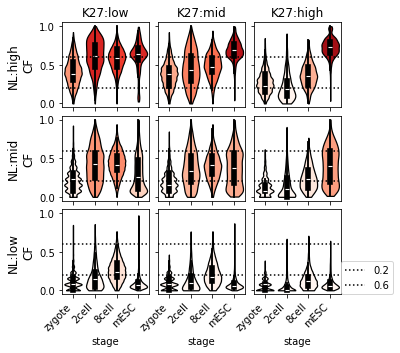

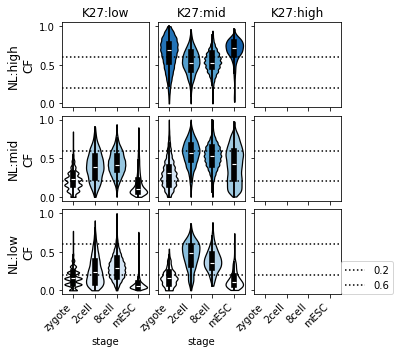

In [71]:
anno_select = anno[(anno.treatment=='no_treatment') & (anno.is_heterozygous)].copy()
group_col = 'stage'


for allele in ['maternal', 'paternal']:

    fig, axes, stat_df = plot_violins_per_cat(anno_select, group_col, allele)
    
    for ax in axes.flatten():
        ax.axhline(0.2, c='k', ls=':', label='0.2')
        ax.axhline(0.6, c='k', ls=':', label='0.6')
    axes[-1,-1].legend(loc=(1,0))

    outfn = FIGOUTDIR + '2_CF_per_category.CF_violins_per_categoty.comparing_all_untreated_stages.%s_allele.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    outfn = outfn.replace('.pdf', '.stat_results.tsv.gz')
    stat_df.to_csv(outfn, header=True, index=False, sep='\t')

## All 2-cell treatment conditions

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)


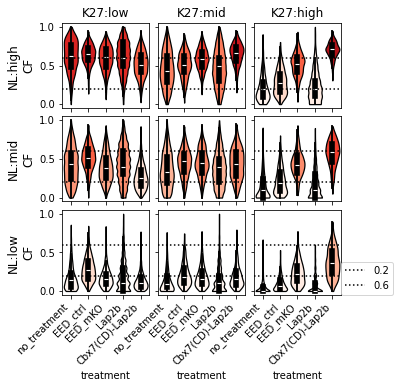

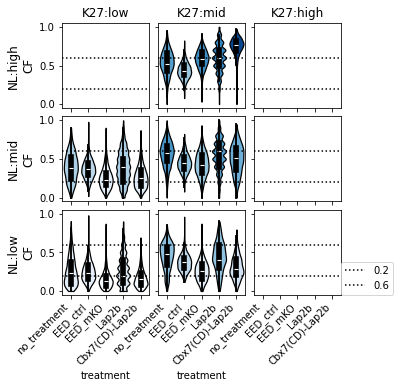

In [72]:
anno_select = anno[(anno.stage=='2cell') & (anno.is_heterozygous)].copy()
group_col = 'treatment'

for allele in ['maternal', 'paternal']:

    fig, axes, stat_df = plot_violins_per_cat(anno_select, group_col, allele)
    
    for ax in axes.flatten():
        ax.axhline(0.2, c='k', ls=':', label='0.2')
        ax.axhline(0.6, c='k', ls=':', label='0.6')
    axes[-1,-1].legend(loc=(1,0))

    outfn = FIGOUTDIR + '2_CF_per_category.CF_violins_per_categoty.comparing_all_2cell_conditions.%s_allele.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    outfn = outfn.replace('.pdf', '.stat_results.tsv.gz')
    stat_df.to_csv(outfn, header=True, index=False, sep='\t')

## 2-cell EED experiment

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)


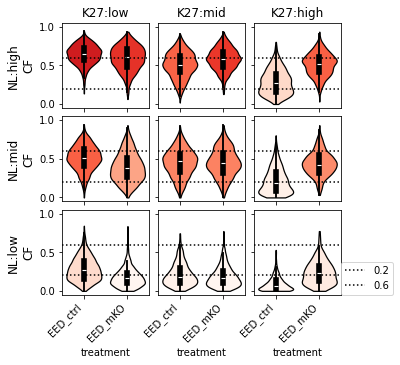

In [73]:
anno_select = anno[(anno.stage=='2cell') & anno.treatment.str.contains('EED') & (anno.is_heterozygous)].copy()
group_col = 'treatment'

for allele in ['maternal', 'paternal']:

    fig, axes, stat_df = plot_violins_per_cat(anno_select, group_col, allele)
    
    for ax in axes.flatten():
        ax.axhline(0.2, c='k', ls=':', label='0.2')
        ax.axhline(0.6, c='k', ls=':', label='0.6')
    axes[-1,-1].legend(loc=(1,0))

    outfn = FIGOUTDIR + '2_CF_per_category.CF_violins_per_categoty.comparing_EED_2cell_conditions.%s_allele.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    outfn = outfn.replace('.pdf', '.stat_results.tsv.gz')
    stat_df.to_csv(outfn, header=True, index=False, sep='\t')

## 2-cell Cbx7-Lap2b experiment

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/4232333342.py:56: RuntimeWarning: Mean of empty slice
  m = np.nanmean(df.loc[df[group_col]==g,'CF'].values)


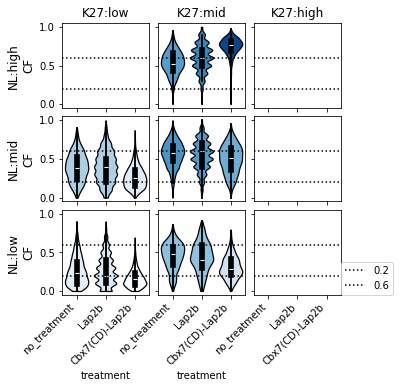

In [74]:
anno_select = anno[(anno.stage=='2cell') & anno.treatment.isin(['no_treatment', 'Lap2b','Cbx7(CD)-Lap2b']) & (anno.is_heterozygous)].copy()
group_col = 'treatment'

for allele in ['maternal', 'paternal']:

    fig, axes, stat_df = plot_violins_per_cat(anno_select, group_col, allele)
    
    for ax in axes.flatten():
        ax.axhline(0.2, c='k', ls=':', label='0.2')
        ax.axhline(0.6, c='k', ls=':', label='0.6')
    axes[-1,-1].legend(loc=(1,0))

    outfn = FIGOUTDIR + '2_CF_per_category.CF_violins_per_categoty.comparing_tethering_2cell_conditions.%s_allele.pdf' % allele
    plt.savefig(outfn, bbox_inches='tight')
    outfn = outfn.replace('.pdf', '.stat_results.tsv.gz')
    stat_df.to_csv(outfn, header=True, index=False, sep='\t')

# Step 4: Example tracks

In [75]:
def plot_example_tracks(chrom, interval, allele):
    # select samples to plot
    conditions_to_plot = {
        'zygote untreated (homozygous)': [('zygote', 'homozygous', 'no_treatment')],
        'zygote untreated (hybrid)': [('zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
        'mESC untreated': [('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment')],
        '2cell untreated': [('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
        '2cell EED mKO experiment': [('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')],
        '2cell Cbx7-Lap2b experiment': [('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')],
        '8cell untreated': [('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')],
        '8cell Cbx7-Lap2b experiment': [('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')]

    }

    # determine bin indices to plot
    i_start = interval[0] // BINSIZE
    i_end = int(np.ceil(interval[1]/BINSIZE))
    X = (np.arange(i_start,i_end) + .5)*BINSIZE / 1e6

    # set up figure
    nrow = 4 + len(conditions_to_plot.keys()) + sum([len(v)==2 for v in conditions_to_plot.values()])
    hr = [4, 1, 4, 1] + [4]*(nrow-4)
    figw = 0.3*(interval[1] - interval[0])/1e6
    fig, axes = plt.subplots(nrow, 1, figsize=(figw, nrow*1.5), sharex=True, gridspec_kw={'height_ratios': hr})
    plt.subplots_adjust(hspace=0.8)
    counter = 0

    # plot H3K27me3
    ax = axes[counter]
    counter += 1
    ext_sample = 'GSE76687_008'
    Y = ext_data['%s_corrected' % allele][ext_sample][chrom][i_start:i_end]
    ax.fill_between(X, 0, Y, lw=0, color=color_dict['target']['H3K27me3'])
    ax.set_ylabel('RPKM')
    ax.set_title('2-cell H3K27me3 - %s allele' % allele)
    ax.set_ylim(0,1.5)
    for t in K27_THRESH:
        ax.axhline(t, c='r', ls=':')

    # plot H3K27me3 categories
    ax = axes[counter]
    counter += 1
    ind = (nl_affinity['chrom']==chrom) & (nl_affinity['start'] >= interval[0]) & (nl_affinity['end'] <= interval[1])
    df = nl_affinity[ind].copy()
    tmp = np.array([df['H3K27me3_%s_cat' % allele].values, df['start'].values, df['end'].values]).T
    for cat, info in itertools.groupby(tmp, key=lambda k: k[0]):
        info = list(info)
        start = info[0][1] / 1e6
        end = info[-1][2] / 1e6
        l = end - start
        c = {'K27:low': 'lightgrey', 'K27:mid': 'grey', 'K27:high': 'black'}[cat]
        R = matplotlib.patches.Rectangle((start,0), l, 1, color=c, lw=0)
        ax.add_patch(R)

    # plot NL affinity
    ax = axes[counter]
    counter += 1
    Y = at_content[chrom][i_start:i_end]
    ax.fill_between(X, 0, Y, lw=0, color='k')
#     ax.plot(X, Y, color='k')
    ax.set_title('NL affinity (AT content)')
    ax.set_ylabel('AT content')
    ax.set_ylim(0.45,0.65)
    for t in AT_NL_AFFINITY_THRESH:
        ax.axhline(t, c='r', ls=':')

    # plot NL affinity categories
    ax = axes[counter]
    counter += 1
    ind = (nl_affinity['chrom']==chrom) & (nl_affinity['start'] >= interval[0]) & (nl_affinity['end'] <= interval[1])
    df = nl_affinity[ind].copy()
    tmp = np.array([df['NL_affinity_cat'].values, df['start'].values, df['end'].values]).T
    for cat, info in itertools.groupby(tmp, key=lambda k: k[0]):
        info = list(info)
        start = info[0][1] / 1e6
        end = info[-1][2] / 1e6
        l = end - start
        c = {'NL:low': 'lightgrey', 'NL:mid': 'grey', 'NL:high': 'black'}[cat]
        R = matplotlib.patches.Rectangle((start,0), l, 1, color=c, lw=0)
        ax.add_patch(R)
        
    # catalogue "delta" axes to ensure they have the same ylim
    ax_delta_ls = list()

    # plot samples
    for title, condition_ls in conditions_to_plot.items():

        ax = axes[counter]
        counter += 1

        # check whether both conditions are available for this allele
        do_allelic = all([condition in contact_freq[allele] for condition in condition_ls])
        if do_allelic:
            ax.set_title('%s - %s allele' % (title, allele))
        else:
            ax.set_title('%s - combined alleles' % title)

        Ydict = dict()

        for condition in condition_ls:

            if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl']:
                a = 0.5
                clr = 'grey'
            else:
                a = 0.5
                clr = color_dict['treatment'][condition[2]]

            if do_allelic:
                Y = contact_freq[allele][condition][chrom][i_start:i_end]
                ax.axhline(0.2, c='k', ls=':')
                ax.axhline(0.6, c='k', ls=':')
            else:
                Y = contact_freq['combined'][condition][chrom][i_start:i_end]
                
            ax.fill_between(
                X, 0, Y, lw=1, color=clr, alpha=a, label=condition[2]
            )
            Ydict[condition[2]] = Y

        ax.set_ylim(0,1)
        ax.set_ylabel('CF')
        ax.legend(loc=(1,0))

        # plot differential CF if applicable
        if len(Ydict.keys()) == 2:
            ax = axes[counter]
            counter += 1

            treatment = condition_ls[1][2]
            control = condition_ls[0][2]

            Ya = Ydict[treatment]
            Yb = Ydict[control]
            Yd = Ya - Yb

            Yd0 = Yd.clip(0, np.inf)
            Yd1 = Yd.clip(-np.inf,0)

            ax.fill_between(X, 0, Yd1, color=color_dict['treatment'][control], lw=0, label='higher in %s' % control)
            ax.fill_between(X, 0, Yd0, color=color_dict['treatment'][treatment], lw=0, label='higher in %s' % treatment)

            ax.legend(loc=(1,0))
            ax.set_ylabel('delta CF')
            ax.set_title('%s - %s allele - differential CF' % (title, allele))
            
            ax_delta_ls.append(ax)


    for ax in axes:
        ax.set_xlim(X[0], X[-1])
    ax.set_xlabel('chromosome %s [Mb]' % chrom)
    
    # set all delta ylims the same
    ylims = np.array([ax.get_ylim() for ax in ax_delta_ls])
    ymin = ylims.min(axis=0)[0]
    ymax = ylims.max(axis=0)[1]
    for ax in ax_delta_ls:
        ax.set_ylim(ymin, ymax)
    
    return
    
    

chr3:106,112,023-145,293,165	
chr5:35,931,752-95,173,075	
chr10:89,694,198-130,694,993	
chr12:51,827,509-103,290,548	
chr16:53,752,068-92,069,782	
chr17:56,542,787-94,987,271

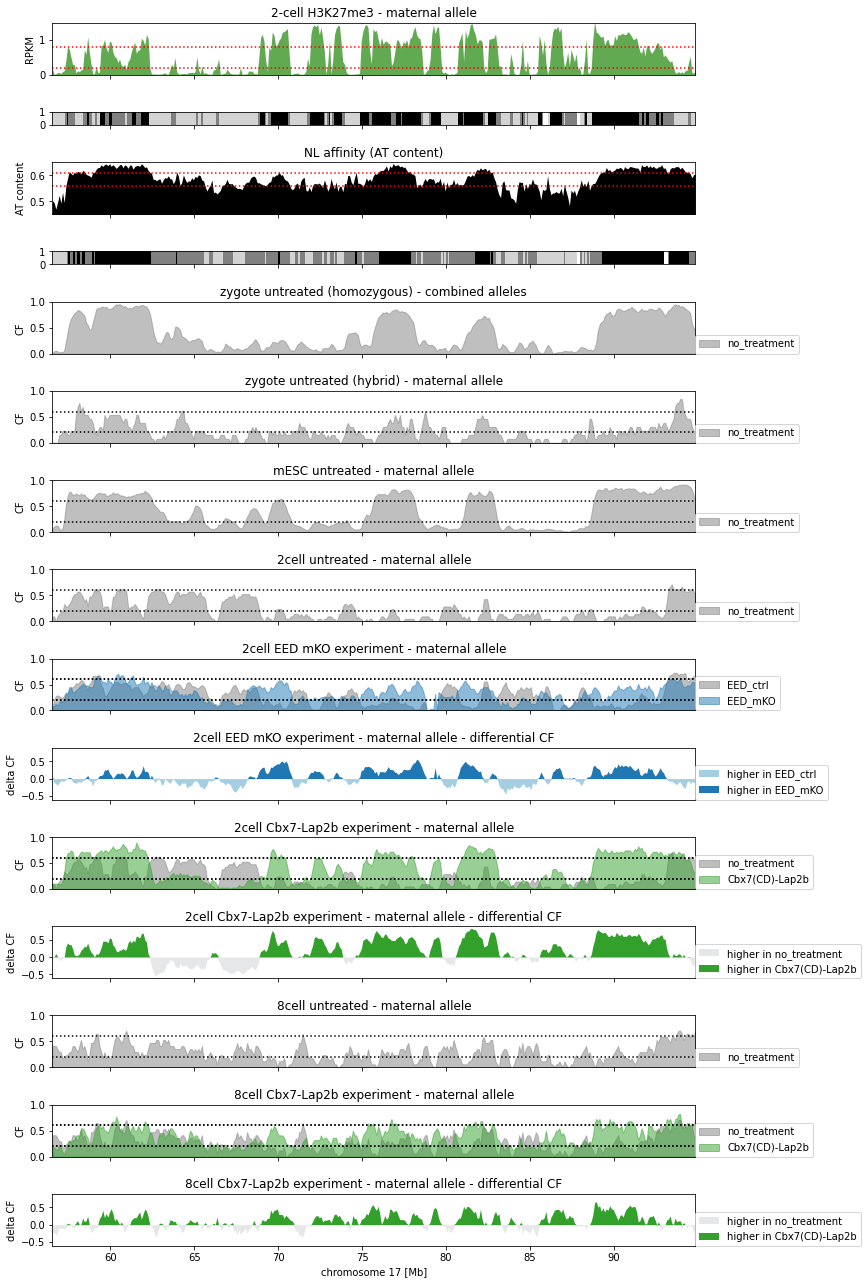

In [76]:
allele = 'maternal'
chrom = '17'
interval = [56500000,94900000]
# interval = [55000000,70000000]

plot_example_tracks(chrom, interval, allele)

In [77]:
regions_to_plot = {
    'region1': ('3', [106100000,145300000]),
    'region1_sub1': ('3', [106100000,117300000]), 
    'region1_sub2': ('3', [115000000,122000000]), 
    'region1_sub3': ('3', [138000000,145300000]),
    'region2': ('5', [35900000,95200000]),
    'region2_sub1': ('5', [35900000,54000000]),
    'region2_sub2': ('5', [75000000,95200000]),
    'region3': ('10', [89700000,130600000]),
    'region3_sub1': ('10', [105000000,116000000]),
    'region4': ('12', [51800000,103300000]),
    'region4_sub1': ('12', [87000000,103000000]),
    'region4_sub2': ('12', [55000000,70000000]),
    'region5': ('16', [53700000,92000000]),
    'region6': ('17', [56500000,94900000])
}



In [78]:
for allele in ['maternal', 'paternal']:
    for name, region in regions_to_plot.items():
        
        chrom = region[0]
        interval = region[1]
        outfn = FIGOUTDIR + 'example_track.%s.chr%s-%d-%d.%s_allele.pdf' % (name, chrom, interval[0], interval[1], allele)
        
        plot_example_tracks(chrom, interval, allele)
        plt.savefig(outfn, bbox_inches='tight')
        plt.close()

# L1 Repeats

In [79]:
REPEATFN = '/Users/f.rang/surfdrive/Kind/data/references/mouse/mm10/repeat_masker/mm10.RepeatMasker.txt.gz'

In [80]:
repeats = pd.read_table(REPEATFN)

In [81]:
# filter out repeat classes that are not of interest
ind = repeats.repClass.isin(['Low_complexity', 'Other', 'Unknown', 'Simple_repeat']) | repeats.repClass.str.contains('\?')
repeats = repeats[~ind]

In [82]:
# format dataframe
repeats = repeats.rename(columns={'genoName': 'chrom', 'genoStart': 'start', 'genoEnd': 'end'})
repeats['chrom'] = repeats['chrom'].apply(func = lambda c: c.strip('chr'))

# filter out repFamilies that are uncertain
ind = repeats.repFamily.str.contains('\?')
repeats = repeats[~ind]

# filter out invalid chromosomes
repeats = repeats[repeats.chrom.isin(chrom_order)]

In [83]:
repeat_density = dict()

g_rep = repeats.groupby(['repClass', 'repFamily', 'repName'])
N = len(list(g_rep))

for (repclass, repfam, repname), df_class in tqdm(g_rep, total=N):
    density = dict()
    
    for chrom in chrom_order:
        df = df_class[df_class.chrom==chrom].copy()
        df['bin_start'] = df['start'] // BINSIZE
        df['bin_end'] = df['end'] // BINSIZE
        
        # initiate empty array
        D = np.zeros(len(mapab[chrom]))
        
        # deal with repeats that fall in exactly 1 bin
        ind = df.bin_start == df.bin_end
        bin_indices = df.loc[ind,'bin_start'].values
        np.add.at(D, bin_indices, 1)
        
        # deal with repeats that span multiple bins
        for _, row in df[~ind].iterrows():
            s = row['start']//BINSIZE
            e = int(np.ceil(row['end'] / BINSIZE))
            D[s:e] += 1
            
        density[chrom] = D.astype(int)
        
    repeat_density[(repclass, repfam, repname)] = density
    
    if (repclass) in repeat_density:
        repeat_density[(repclass)] = {c: repeat_density[(repclass)][c] + density[c] for c in density}
    else:
        repeat_density[(repclass)] = density
        
    if (repclass, repfam) in repeat_density:
        repeat_density[(repclass, repfam)] = {c: repeat_density[(repclass, repfam)][c] + density[c] for c in density}
    else:
        repeat_density[(repclass, repfam)] = density

  0%|          | 0/1151 [00:00<?, ?it/s]

In [84]:
n = repeats[repeats.repFamily=='L1'].groupby(['repClass', 'repFamily', 'repName']).size()
n.sort_values()[-20:]

repClass  repFamily  repName
LINE      L1         L1Md_F3    16093
                     Lx5        16240
                     Lx5c       16385
                     L1M5       16570
                     L1Md_A     16802
                     Lx6        18148
                     L1M2       18471
                     Lx2        18496
                     L1_Mur2    20617
                     L1_Mus2    21044
                     L1Md_T     23639
                     Lx8b       24156
                     Lx         24769
                     L1_Mus1    27127
                     L1_Mur3    27377
                     Lx7        40034
                     L1_Mus3    48280
                     Lx8        49084
                     Lx9        49110
                     L1Md_F2    64716
dtype: int64

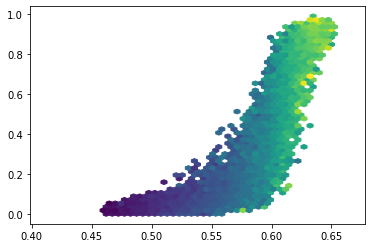

In [85]:
roi = ('LINE', 'L1')

C = np.concatenate([repeat_density[roi][c][cluster_bins_ind[c]] for c in selected_chroms])
X = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])
Y = np.concatenate([contact_freq['combined'][('zygote', 'homozygous', 'no_treatment')][c][cluster_bins_ind[c]] for c in selected_chroms])

fig, ax = plt.subplots()

ax.hexbin(X, Y, C, gridsize=50, mincnt=2)

# Correlating CF to NL affinity

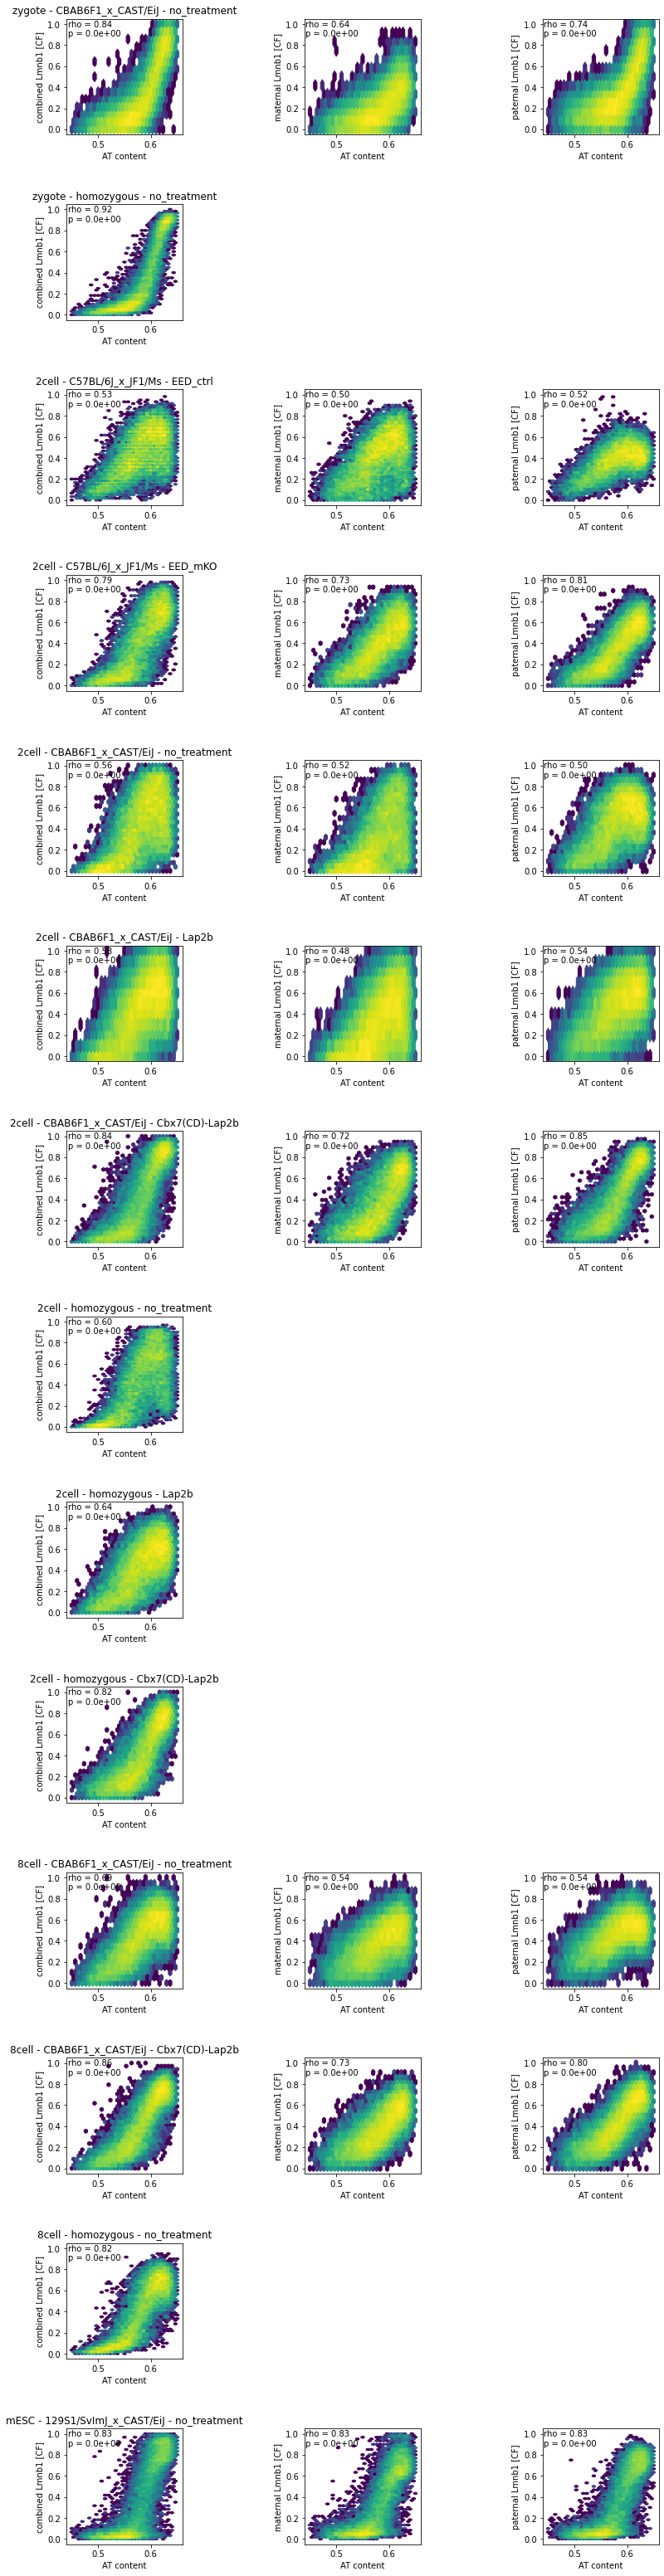

In [86]:
X = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])

g_anno = anno.groupby(['stage', 'genotype', 'treatment'])
nrow = len(list(g_anno))
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4.5, nrow*4))
plt.subplots_adjust(hspace=.6, wspace=.6)
irow = -1

for condition, df in g_anno:
    irow += 1
    
    for icol, allele in enumerate(['combined', 'maternal', 'paternal']):
        
        ax = axes[irow,icol]
        if condition not in contact_freq[allele]:
            ax.remove()
            continue
            
        if icol == 0:
            ax.set_title('%s - %s - %s' % condition)
            
        # collect CF
        Y = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
        
        # determine which regions should be filtered out
        filt_ind = np.concatenate([mapab[c][cluster_bins_ind[c]] for c in selected_chroms]) > MINMAP
        if allele != 'combined':
            a_filt = np.concatenate([allele_filt_gt[condition[1]][c][cluster_bins_ind[c]] for c in selected_chroms])
            filt_ind = filt_ind & a_filt
            Nsamples = df.DamID_PASS_allelic.sum()
        else:
            Nsamples = df.DamID_PASS.sum()
         
        # plot
        y_gs = min(int(Nsamples/2),30)
        gs = (30, y_gs)
        
        ax.hexbin(X[filt_ind], Y[filt_ind], bins='log', extent=[0.45, 0.65, 0, 1], gridsize=gs)
        ax.set_xlabel('AT content')
        ax.set_ylabel('%s Lmnb1 [CF]' % allele)
        ax.set_box_aspect(1)
         
        # correlation
        s, p = stats.spearmanr(X[filt_ind], Y[filt_ind])
        t = 'rho = %.2f\np = %.1e' % (s, p)
        ax.text(0.01, 0.99, t, transform=ax.transAxes, ha='left', va='top')
        
outfn = FIGOUTDIR + '3_Other.correlation_NL_affinity_versus_CF.pdf'
plt.savefig(outfn, bbox_inches='tight')

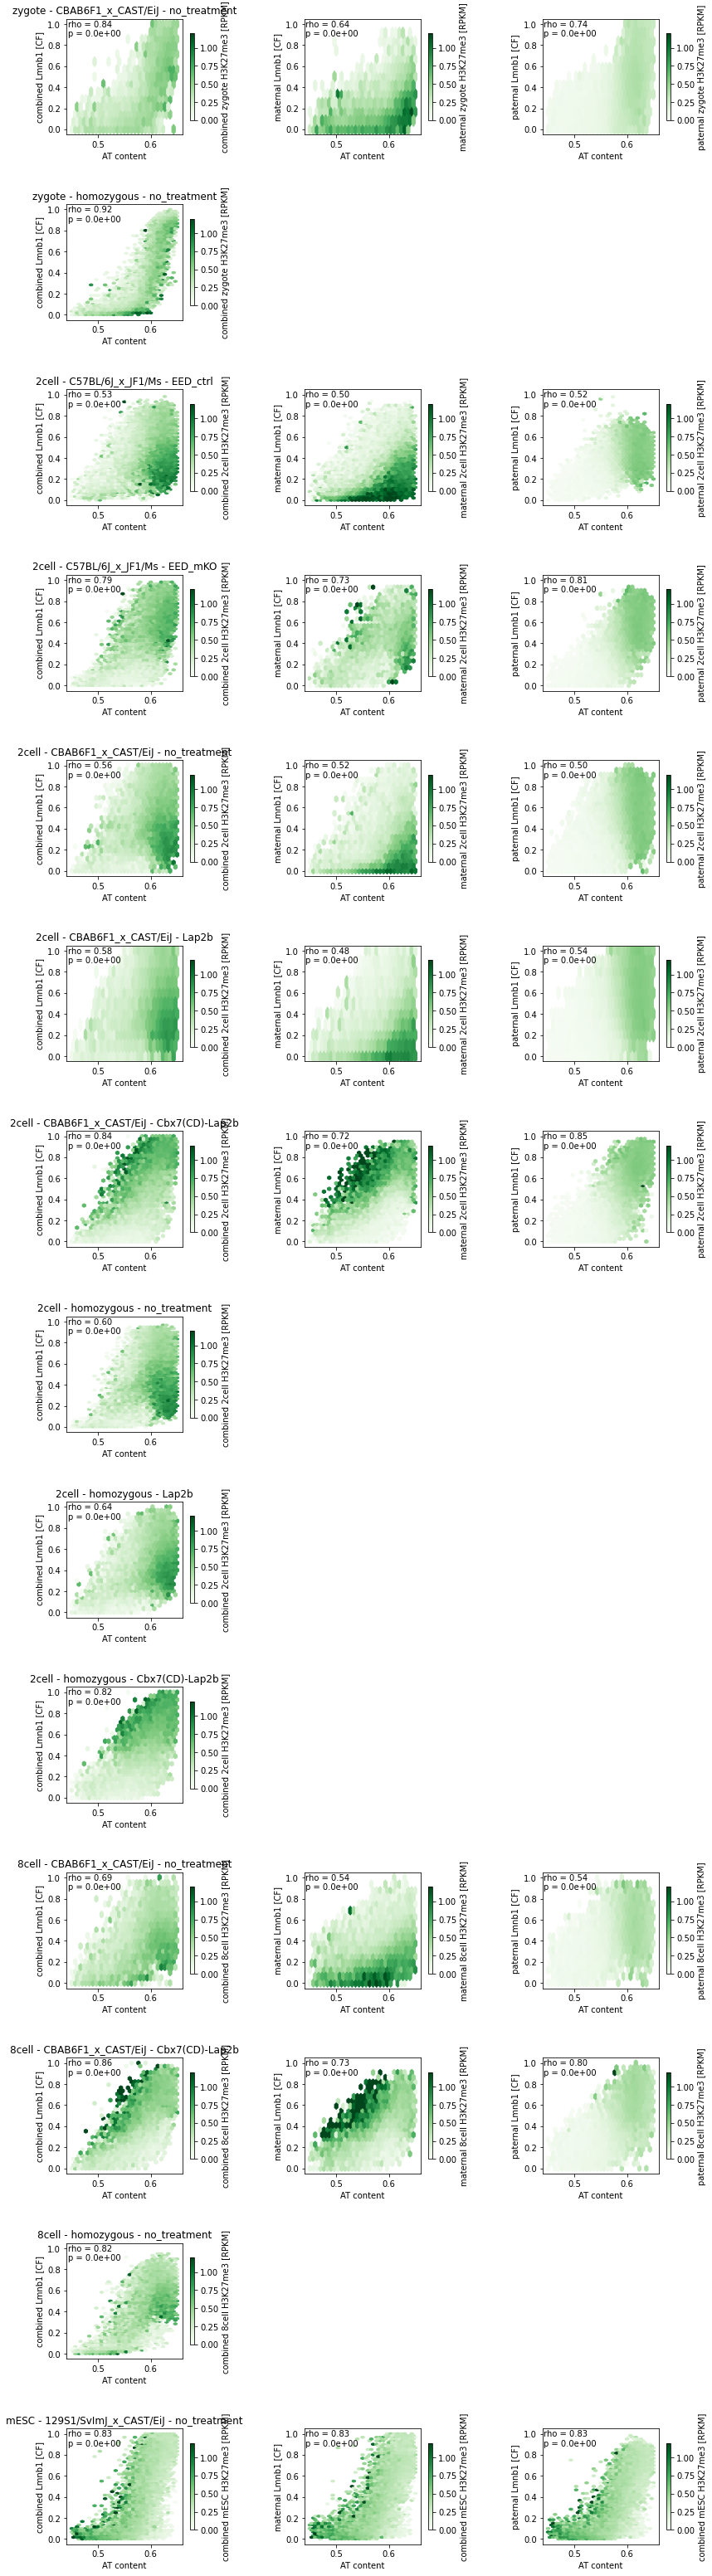

In [87]:
stage_sample_match = {
    'zygote': 'GSE76687_006',
    '2cell': 'GSE76687_008',
    '8cell': 'GSE76687_009',
    'mESC': 'GSE76687_018'
}

X = np.concatenate([at_content[c][cluster_bins_ind[c]] for c in selected_chroms])

g_anno = anno.groupby(['stage', 'genotype', 'treatment'])
nrow = len(list(g_anno))
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4.5, nrow*4))
plt.subplots_adjust(hspace=.6, wspace=.6)
irow = -1

for condition, df in g_anno:
    irow += 1
    
    for icol, allele in enumerate(['combined', 'maternal', 'paternal']):
        
        ax = axes[irow,icol]
        if condition not in contact_freq[allele]:
            ax.remove()
            continue
            
        if icol == 0:
            ax.set_title('%s - %s - %s' % condition)
            
        # collect CF
        Y = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])
        
        # determine which regions should be filtered out
        filt_ind = np.concatenate([mapab[c][cluster_bins_ind[c]] for c in selected_chroms]) > MINMAP
        if allele != 'combined':
            a_filt = np.concatenate([allele_filt_gt[condition[1]][c][cluster_bins_ind[c]] for c in selected_chroms])
            filt_ind = filt_ind & a_filt
            Nsamples = df.DamID_PASS_allelic.sum()
        else:
            Nsamples = df.DamID_PASS.sum()
        
        # collect H3K27me3 signal
        ext_sample = stage_sample_match[condition[0]]
        if (ext_sample not in ext_data[allele]) or (allele == 'combined'):
            C = np.concatenate([ext_data['combined'][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms])
            cbarlab = 'combined %s H3K27me3 [RPKM]' % condition[0]
        else:
            C = np.concatenate([ext_data['%s_corrected' % allele][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms])
            cbarlab = '%s %s H3K27me3 [RPKM]' % (allele, condition[0])
            a_filt = np.concatenate([ext_data['allele_vis'][ext_sample][c][cluster_bins_ind[c]] for c in selected_chroms]) > 0.1
            C[~a_filt] = np.nan
        

         
        # plot
        y_gs = min(int(Nsamples/2),30)
        gs = (30, y_gs)
        
        p = ax.hexbin(
            X[filt_ind], Y[filt_ind], C[filt_ind], reduce_C_function=np.nanmean, 
            extent=[0.45, 0.65, 0, 1], gridsize=gs, mincnt=0, vmin=0, vmax=1.2, cmap='Greens'
        )
        cbar = plt.colorbar(p, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel(cbarlab)
        
        ax.set_xlabel('AT content')
        ax.set_ylabel('%s Lmnb1 [CF]' % allele)
        ax.set_box_aspect(1)
         
        # correlation
        s, p = stats.spearmanr(X[filt_ind], Y[filt_ind])
        t = 'rho = %.2f\np = %.1e' % (s, p)
        ax.text(0.01, 0.99, t, transform=ax.transAxes, ha='left', va='top')
        
outfn = FIGOUTDIR + '3_Other.correlation_NL_affinity_versus_CF.colored_by_H3K27me3.pdf'
plt.savefig(outfn, bbox_inches='tight')

# TEST

In [88]:
def plot_NLaffinity_split_K27_vs_CF(allele, visualization, for_png=False):
    
    # define condition comparisons of interest
    comparison_ls = {
        '2cell EED mKO vs WT': [('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')],
        '2cell Cbx7-Lap2b vs Lap2b': [('2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b'), ('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')],
        '2cell Cbx7-Lap2b vs untreated': [('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')],
        '8cell Cbx7-Lap2b vs untreated': [('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')]
    }
    
    # plot set-up
    nrow = len(comparison_ls.keys())
    ncol = 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*4))
    plt.subplots_adjust(hspace=.6)

    # iterate over sample pairs
    for irow, comparison in enumerate(comparison_ls.keys()):

        to_plot = nl_affinity.copy()
        for condition in comparison_ls[comparison]:
            D = np.concatenate([contact_freq[allele][condition][c][cluster_bins_ind[c]] for c in selected_chroms])

            if allele != 'combined':
                filt = np.concatenate([allele_filt_gt[condition[1]][c][cluster_bins_ind[c]] for c in selected_chroms])
                D[~filt] = np.nan

            to_plot[condition[2]] = D

        for icol, nl_cat in enumerate(['NL:low', 'NL:mid', 'NL:high']):

            ax = axes[irow,icol]

            df = to_plot[to_plot['NL_affinity_cat']==nl_cat].copy()
            X = df['H3K27me3_%s' % allele].values.clip(0,1.5)

            for condition in comparison_ls[comparison]:

                Y = df[condition[2]].values
                ind = (anno.stage==condition[0])&(anno.genotype==condition[1])&(anno.treatment==condition[2])
                nsamples = (ind & anno.DamID_PASS_allelic).sum()
                gs = min(30,int(nsamples/2))

                # plot mean +/- std
                m_ls = list()
                s_ls = list()
                q_ls = list()
                x_ls = np.linspace(0,1.5,20)

                for x in x_ls:
                    ind = (X > (x-.1)) & (X < (x+.1))
                    m_ls.append(np.nanmean(Y[ind]))
                    s_ls.append(np.nanstd(Y[ind]))
                    q_ls.append(np.nanpercentile(Y[ind], [1,10,25,50,75,90,99]))
                m_ls = np.array(m_ls)
                s_ls = np.array(s_ls)
                q_ls = np.array(q_ls).T

                clr1 = 'lightsteelblue' if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl'] else 'firebrick'
                clr2 = 'slategrey' if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl'] else 'maroon'
                cmap = 'Blues' if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl'] else 'Reds'

                # visualization 0: scatter + mean 
                if visualization == 0:
                    ax.scatter(X, Y, alpha=1, label=condition[2], s=10, c=clr1)
                    ax.plot(x_ls, m_ls, c=clr2, label='%s mean' % condition[2])

                # visualization 1: hexbin + mean
                elif visualization == 1:
                    ax.hexbin(X, Y, bins='log', gridsize=(40,gs), extent=[0,1.5,0,1], cmap=cmap, alpha=0.4, linewidths=0)
                    ax.plot(x_ls, m_ls, c=clr2, label='%s mean' % condition[2])

                # visualization 2: kde + mean
                elif visualization == 2:
                    sns.kdeplot(x=X, y=Y, ax=ax, label=condition[2], alpha=.4, color=clr1, bw_adjust=2, fill=True)
                    ax.plot(x_ls, m_ls, c=clr2, label='%s mean' % condition[2])

                # visualization 3: mean + std
                elif visualization == 3:
                    ax.plot(x_ls, m_ls, c=clr2, label='%s mean +/- std' % condition[2])
                    ax.fill_between(x_ls, m_ls-s_ls, m_ls+s_ls, alpha=0.3)
 
                # visualization 4: mean + quantiles
                elif visualization == 4:
                    clr1 = 'royalblue' if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl'] else 'tomato'
                    clr2 = 'darkblue' if condition[2] in ['no_treatment', 'Lap2b', 'EED_ctrl'] else 'maroon'
                    qnames = np.array(['1-10 pct', '10-25 pct', '25-50 pct', '50-75 pct', '75-90 pct', '90-99 pct'])
                    avals = np.array([0.1, 0.25, 0.5, 0.5, 0.25, 0.1])

                    # plot area between quantiles
                    for i in range(1,3):
                        ax.fill_between(x_ls, q_ls[i,:], q_ls[i+1,:], color=clr1, alpha=avals[i], label=qnames[i], lw=0)
                        ax.fill_between(x_ls, q_ls[-i-2,:], q_ls[-i-1,:], color=clr1, alpha=avals[-i-1], label=qnames[-i-1], lw=0)
                    ax.plot(x_ls, q_ls[3,:], c=clr2, label = '%s median' % condition[2])

            ax.set_xlim(-0.05,1.5)
            ax.set_ylim(-.05,1.05)
            if not for_png:
                ax.axhline(0.2, c='k', ls=':')
                ax.axhline(0.6, c='k', ls=':')
                ax.axvline(0.2, c='k', ls=':')
                ax.axvline(0.8, c='k', ls=':')
            ax.set_title('%s\n%s - %s allele' % (comparison, nl_cat, allele))

            if icol == 2:
                ax.legend(loc=(1,0))
            ax.set_xlabel('H3K27me3 [RPKM]')
            ax.set_ylabel('CF')
    
    return fig, axes

In [89]:
vis_dict = {
    'scatter_and_mean': 0
#     'hexbin_and_mean': 1,
#     'density_and_mean': 2,
#     'mean_and_std': 3,
#     'median_and_percentiles': 4
}

for visname, vis in vis_dict.items():
    
    for allele in ['maternal', 'paternal']:
        
        fig, axes = plot_NLaffinity_split_K27_vs_CF(allele, vis)
        outfn = FIGOUTDIR + '3_Other.relationship_between_K27_and_CF.split_on_NL_affinity.%s_allele.%s.pdf' % (allele, visname)
        plt.savefig(outfn, bbox_inches='tight')
        plt.close()
        
        if vis == 0:
            
            # try save individual axes
            nrows = axes.shape[0]
            for i in range(nrows):
                fig, axes = plot_NLaffinity_split_K27_vs_CF(allele, vis)
                
                for j in range(nrows):
                    if j != i:
                        for ax in axes[j,:]:
                            ax.remove()
                
                outfn_sub = outfn.replace('.pdf', '.part%d.pdf' % (i+1))
                plt.savefig(outfn_sub, bbox_inches='tight')
                plt.close()
            
            # save as png
            fig, axes = plot_NLaffinity_split_K27_vs_CF(allele, vis, for_png=True)
            outfn = outfn.replace('.pdf', '.png')
            plt.savefig(outfn, bbox_inches='tight')
            plt.close()
            


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:52: RuntimeWarning: Mean of empty slice
  m_ls.append(np.nanmean(Y[ind]))
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:52: RuntimeWarning: Mean of empty slice
  m_ls.append(np.nanmean(Y[ind]))
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: Runti

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:52: RuntimeWarning: Mean of empty slice
  m_ls.append(np.nanmean(Y[ind]))
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  q_ls = np.array(q_ls).T
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:52: RuntimeWarning: Mean of empty slice
  m_ls.append(np.nanmean(Y[ind]))
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70067/1138989564.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  q_ls = np.array(q_ls).T
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/l